In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sympy import symbols, Function, Eq, diff
from sympy.printing.latex import latex
from IPython.display import display, Math
from sympy import dsolve
from sympy import lambdify

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import pinn_lib as pinn

In [3]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f'Number of available GPUs: {num_gpus}')
    
    # Get detailed information about each GPU
    for i in range(num_gpus):
        print(f'GPU {i}: {torch.cuda.get_device_name(i)}')
        print(f'  - Total Memory: {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB')
        print(f'  - Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}')
        print(f'  - CUDA Capability: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}')
else:
    print('CUDA is not available.')

Number of available GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB
  - Total Memory: 39.67 GB
  - Multiprocessors: 108
  - CUDA Capability: 8.0


# Example ODEs

This set of ODEs (Ordinary Differential Equations) will be used to test the performance and accuracy of the PINN model. For each ODE, we use the same initial condition: $y(0) = 1$. Once we define the ODE, we will also provide its analytical solution for comparison. Then, using `sympy`, we will derive the solution into a callable function that can be used to evaluate the solution at any point.

In [4]:
def ode_residual(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: dy/dx + y = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return y_pred_x + y_pred

# show the ODE and its solution
x = symbols('x')
y = Function('y')(x)
ode = Eq(diff(y, x) + y, 0)
display(Math(latex(ode)))

# solve the ODE with initial condition y(0) = 1
solution = dsolve(ode, y, ics={y.subs(x, 0): 1})
display(Math(latex(solution)))

y_sol = solution.rhs
y_func = lambdify(x, y_sol, 'numpy')
y_func(0.0)  # should be 1.0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

np.float64(1.0)

In [5]:
def test_and_plot(params: pinn.TrainParams, ode_residual_func, length: str, savefig: str = None, save_model: bool = False, ic_dx: list = None, ic_dx2: list = None):
    if ic_dx is not None or ic_dx2 is not None:
        model = pinn.traindx(params, ode_residual_func, ic_dx, ic_dx2, length=length, save_results=True)
    else:   
        model = pinn.train(params, ode_residual_func, length=length, save_results=True, output_model=save_model)
    
    plt.loglog(params.epochs, params.loss)
    plt.xlim(1, params.epochs[-1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs - {str(params.activation)} Activation, Time - {params.time:.2f}s')
    plt.grid(True)
    
    if savefig:
        plt.savefig(savefig)
    plt.show()

    if save_model:
        return model

In [6]:
def ode_accuracy_test(model: pinn.PINN, y_exact_func: callable, num_points: int = 100):
    # compare the model and the actual solution
    x_test = torch.linspace(0, 1, num_points).view(-1, 1)
    y_test = model(x_test).detach().numpy()
    y_exact = y_exact_func(x_test.numpy())
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].plot(x_test.numpy(), y_test, label='PINN Prediction')
    axs[0].plot(x_test.numpy(), y_exact, label='Exact Solution', linestyle='dashed')
    axs[0].set_xlim(0, 1)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_title('PINN vs Exact Solution')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(x_test.numpy(), np.abs(y_test - y_exact), color='red', label='Absolute Error') 
    axs[1].set_xlim(0, 1)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('Absolute Error')
    axs[1].set_title('Absolute Error')
    axs[1].grid(True)
    print(f'Max Absolute Error: {np.max(np.abs(y_test - y_exact)):.2e}')
    print(f'Mean Absolute Error: {np.mean(np.abs(y_test - y_exact)):.2e}')
    print(f'Min Absolute Error: {np.min(np.abs(y_test - y_exact)):.2e}')

    plt.show()

100%|██████████| 10000/10000 [00:23<00:00, 428.71it/s]


Training completed in 23.33s


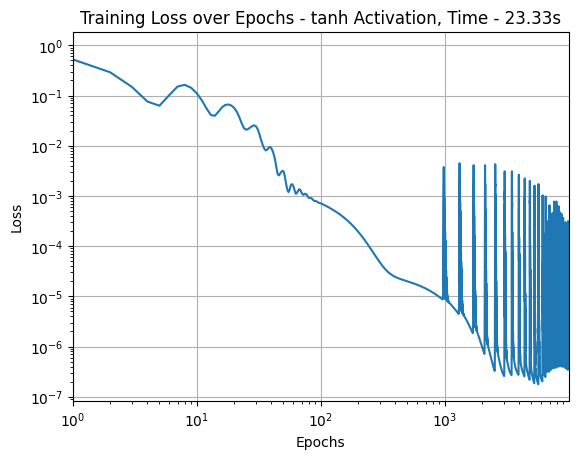

Max Absolute Error: 2.00e-04
Mean Absolute Error: 1.47e-04
Min Absolute Error: 8.42e-05


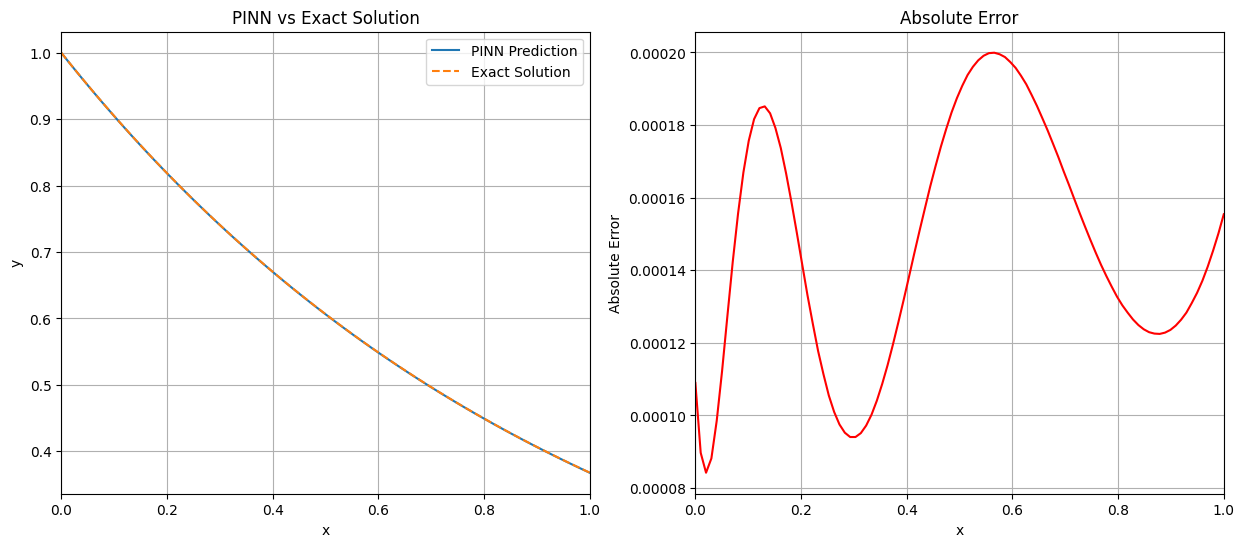

In [7]:
params_test = pinn.TrainParams(
    optimizer=optim.Adam,
    activation='tanh',
    ic=[0.0, 1.0],  # Example: y(0) = 1
    layers=[1, 100, 100, 100, 1]
)

model = test_and_plot(params_test, ode_residual, length='standard', save_model=True)
# pinn.train(params_test, ode_residual, length='standard', save_results=True)

ode_accuracy_test(model, y_func)

As can be seen from the plots, the PINN model is generally able to approximate the solution of the ODEs quite well, and the loss is similar to the absolute error between the PINN prediction and the analytical solution. The fluctuations in the loss somewhat accurately reflect the fluctuations in the error.

In [8]:
def ode_residual_2(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: d2y/dx2 + y = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_pred_xx = torch.autograd.grad(y_pred_x, x, grad_outputs=torch.ones_like(y_pred_x), create_graph=True)[0]
    return y_pred_xx + y_pred

ode_2 = Eq(diff(y, x, x) + y, 0)
display(Math(latex(ode_2)))

solution_2 = dsolve(ode_2, y, ics={y.subs(x, 0): 1, diff(y, x).subs(x, 0): 0})
display(Math(latex(solution_2)))

y_sol_2 = solution_2.rhs
y_func_2 = lambdify(x, y_sol_2, 'numpy')
y_func_2(0.0)  # should be 1.0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

np.float64(1.0)

Here, we do not provide the 1st derivative initial condition, and the PINN model may produce the result which is accurate only at the initial point, but diverges later.

100%|██████████| 10000/10000 [00:34<00:00, 289.71it/s]


Training completed in 34.52s


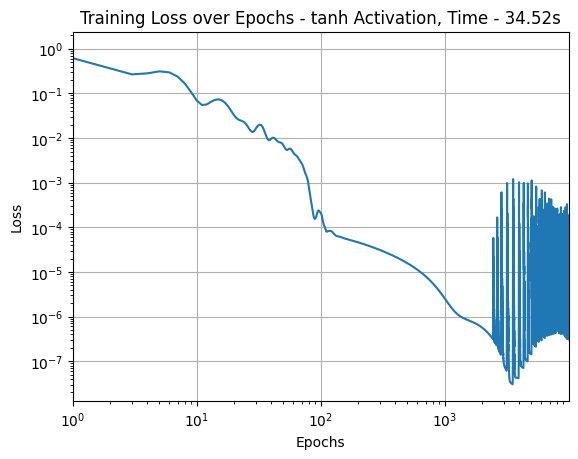

Max Absolute Error: 5.56e-01
Mean Absolute Error: 3.05e-01
Min Absolute Error: 1.92e-03


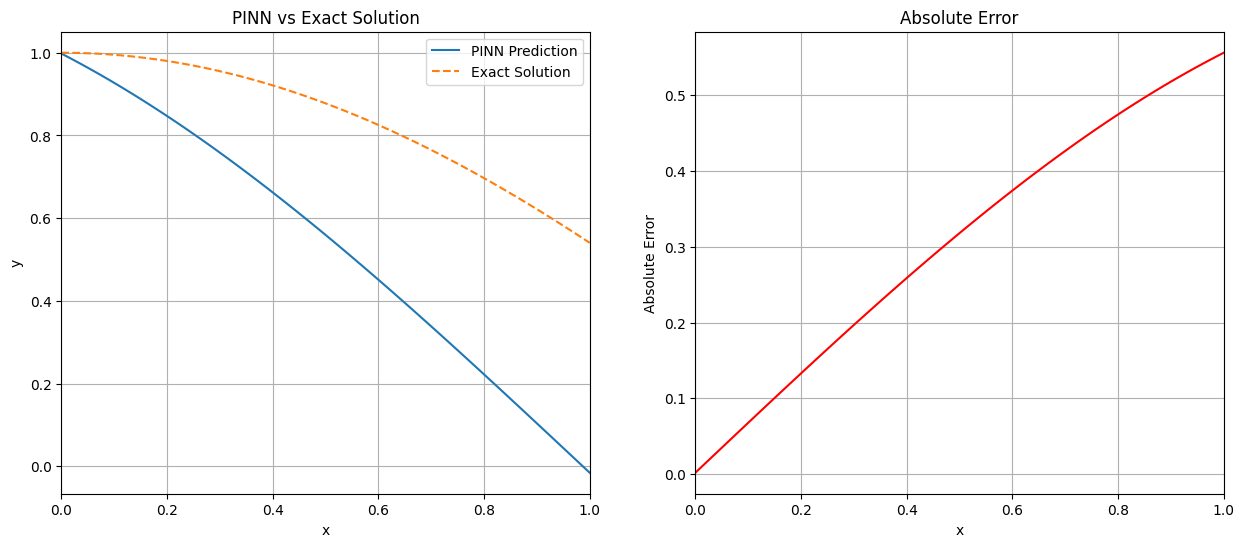

In [9]:
model = test_and_plot(params_test, ode_residual_2, length='standard', save_model=True)
ode_accuracy_test(model, y_func_2)

Just for these examples, we created the `traindx` function (slight modification of `train`; diffferent functions to ensure that the performance tests use the simplest training) in `pinn_lib.py` to provide the 1st and 2nd derivative initial conditions, and return the trained model for further evaluation. Let's try again.

100%|██████████| 10000/10000 [00:40<00:00, 246.11it/s]


Training completed in 40.64s


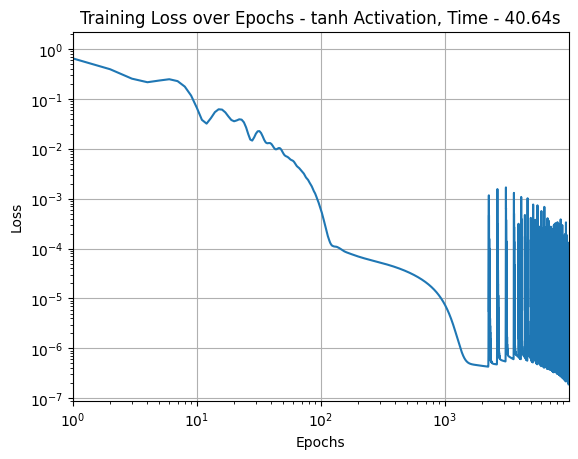

Max Absolute Error: 3.19e-05
Mean Absolute Error: 2.78e-05
Min Absolute Error: 2.42e-05


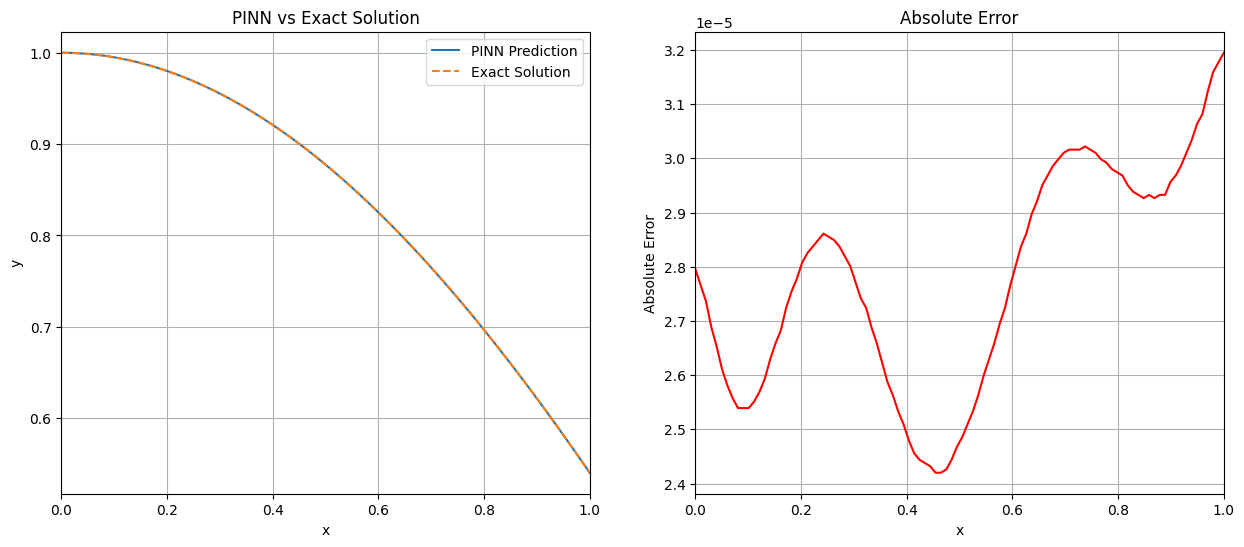

In [10]:
model = test_and_plot(params_test, ode_residual_2, length='standard', save_model=True, ic_dx=[0.0, 0.0])
ode_accuracy_test(model, y_func_2)

As we expected, with the additional initial condition, the PINN model is able to produce a much more accurate result. A few more things that can be seen here: 1) the actual error is much lower than in the case of only 1 initial condition even for 1st order ODEs; 2) the time is longer only for $\approx 7$ seconds, which is not much considering the significant improvement in accuracy. However, almost twice longer than for the 1st order ODEs.

In [11]:
def ode_residual_3(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: dy/dx + x^2 * y - 2x^2 = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return y_pred_x + x**2 * y_pred - 2 * x**2

ode_3 = Eq(diff(y, x) + x**2 * y - 2 * x**2, 0)
display(Math(latex(ode_3)))

solution_3 = dsolve(ode_3, y, ics={y.subs(x, 0): 1})
display(Math(latex(solution_3)))
y_sol_3 = solution_3.rhs
y_func_3 = lambdify(x, y_sol_3, 'numpy')
y_func_3(0.0)  # should be 1.0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

np.float64(1.0)

100%|██████████| 10000/10000 [00:23<00:00, 423.85it/s]


Training completed in 23.60s


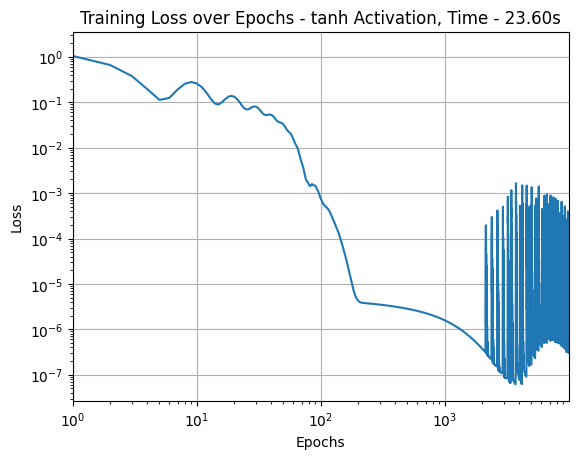

Max Absolute Error: 5.53e-05
Mean Absolute Error: 2.62e-05
Min Absolute Error: 2.38e-07


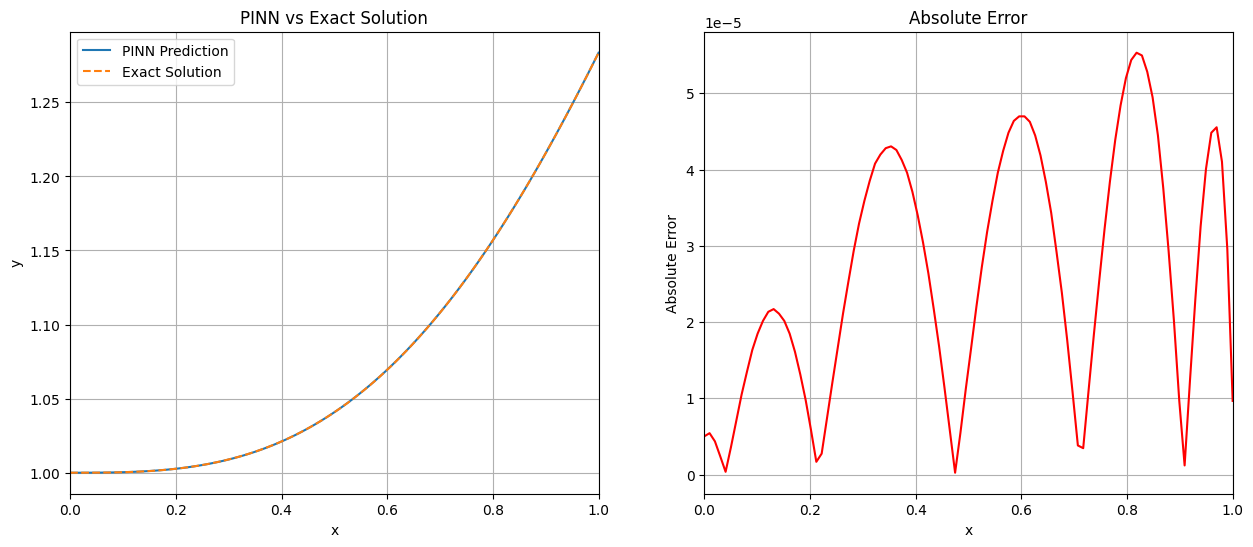

In [12]:
model = test_and_plot(params_test, ode_residual_3, length='standard', save_model=True)
ode_accuracy_test(model, y_func_3)

In [13]:
def ode_residual_4(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: d2y/dx2 - dy/dx + 4y = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_pred_xx = torch.autograd.grad(y_pred_x, x, grad_outputs=torch.ones_like(y_pred_x), create_graph=True)[0]  
    return y_pred_xx - y_pred_x + 4 * y_pred

ode_4 = Eq(diff(y, x, x) - diff(y, x) + 4 * y, 0)
display(Math(latex(ode_4)))

solution_4 = dsolve(ode_4, y, ics={y.subs(x, 0): 1, diff(y, x).subs(x, 0): 0})
display(Math(latex(solution_4)))
y_sol_4 = solution_4.rhs
y_func_4 = lambdify(x, y_sol_4, 'numpy')
y_func_4(0.0)  # should be 1.0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

np.float64(1.0)

100%|██████████| 10000/10000 [00:41<00:00, 240.60it/s]


Training completed in 41.56s


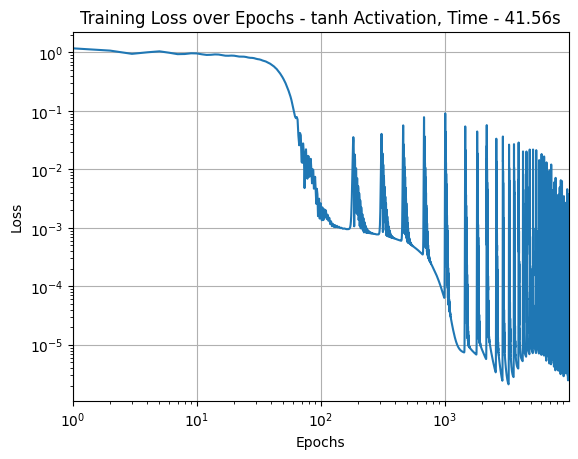

Max Absolute Error: 6.30e-03
Mean Absolute Error: 5.50e-03
Min Absolute Error: 4.58e-03


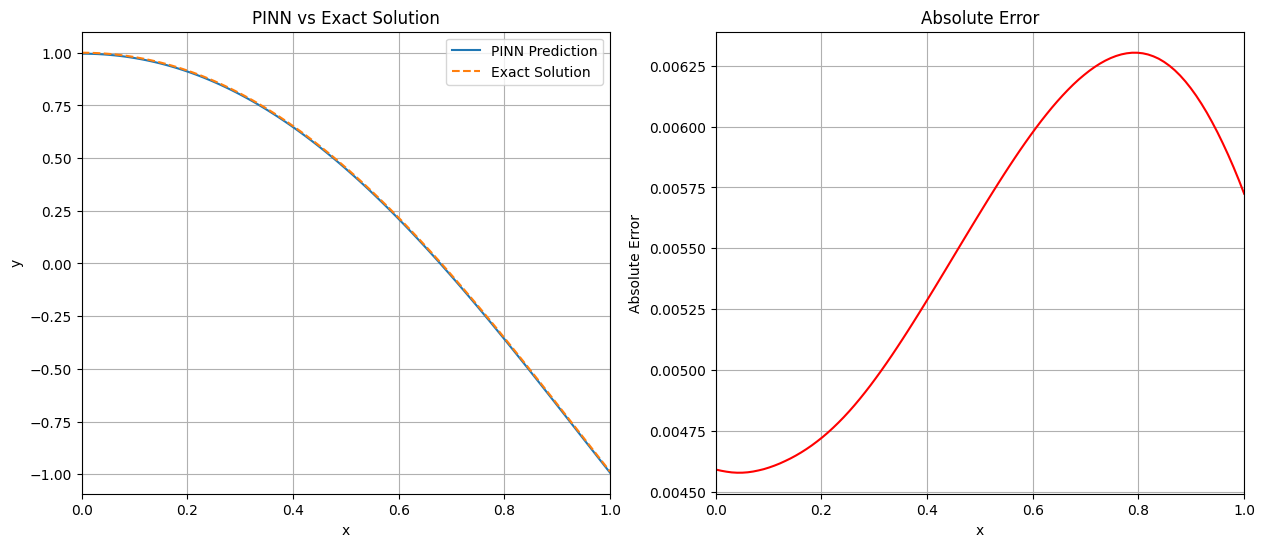

In [14]:
model = test_and_plot(params_test, ode_residual_4, length='standard', save_model=True, ic_dx=[0.0, 0.0])
ode_accuracy_test(model, y_func_4)

In [15]:
def ode_residual_5(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: d3y/dx3 - d2y/dx2 - x = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_pred_xx = torch.autograd.grad(y_pred_x, x, grad_outputs=torch.ones_like(y_pred_x), create_graph=True)[0]  
    y_pred_xxx = torch.autograd.grad(y_pred_xx, x, grad_outputs=torch.ones_like(y_pred_xx), create_graph=True)[0]
    return y_pred_xxx - y_pred_xx - x

ode_5 = Eq(diff(y, x, x, x) - diff(y, x, x) - x, 0)
display(Math(latex(ode_5)))

solution_5 = dsolve(ode_5, y, ics={y.subs(x, 0): 1, diff(y, x).subs(x, 0): 0, diff(y, x, x).subs(x, 0): 0})
display(Math(latex(solution_5)))
y_sol_5 = solution_5.rhs
y_func_5 = lambdify(x, y_sol_5, 'numpy')
y_func_5(0.0)  # should be 1.0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

np.float64(1.0)

100%|██████████| 10000/10000 [01:23<00:00, 119.61it/s]


Training completed in 83.61s


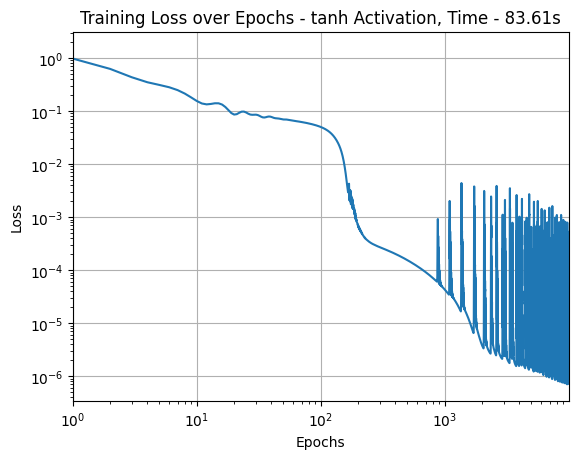

Max Absolute Error: 2.72e-04
Mean Absolute Error: 2.44e-04
Min Absolute Error: 2.25e-04


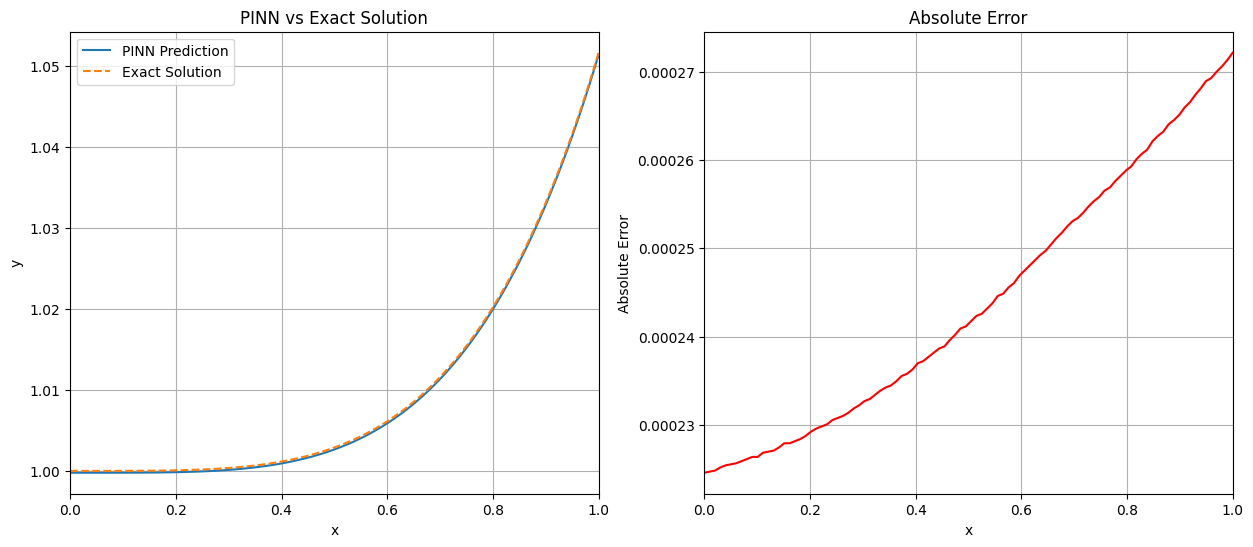

In [16]:
model = test_and_plot(params_test, ode_residual_5, length='standard', save_model=True, ic_dx=[0.0, 0.0], ic_dx2=[0.0, 0.0])
ode_accuracy_test(model, y_func_5)

Now, we will test our PINN model on a 3rd order ODE with more complex solution. 

In [17]:
def ode_residual_5extra(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: d3y/dx3 - d2y/dx2 + 4y = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_pred_xx = torch.autograd.grad(y_pred_x, x, grad_outputs=torch.ones_like(y_pred_x), create_graph=True)[0]  
    y_pred_xxx = torch.autograd.grad(y_pred_xx, x, grad_outputs=torch.ones_like(y_pred_xx), create_graph=True)[0]
    return y_pred_xxx - y_pred_xx + 4 * y_pred

ode_5extra = Eq(diff(y, x, x, x) - diff(y, x, x) + 4 * y, 0)
display(Math(latex(ode_5extra)))

solution_5extra = dsolve(ode_5extra, y, ics={y.subs(x, 0): 1, diff(y, x).subs(x, 0): 0, diff(y, x, x).subs(x, 0): 0})
display(Math(latex(solution_5extra)))
y_sol_5extra = solution_5extra.rhs
y_func_5extra = lambdify(x, y_sol_5extra, 'numpy')
y_func_5extra(0.0)  # should be 1.0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

np.float64(0.9999999999999996)

100%|██████████| 10000/10000 [01:21<00:00, 122.76it/s]


Training completed in 81.46s


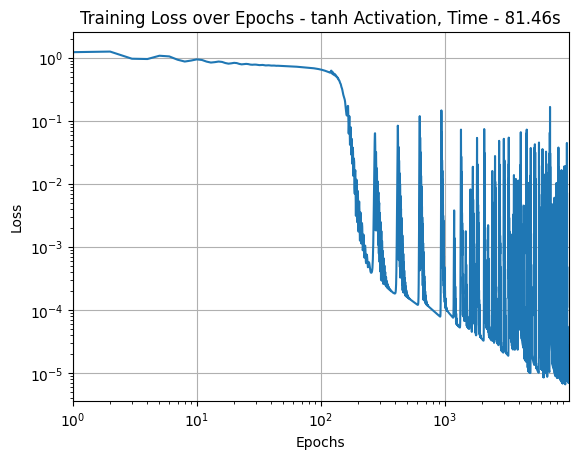

Max Absolute Error: 1.52e-03
Mean Absolute Error: 1.01e-03
Min Absolute Error: 7.20e-04


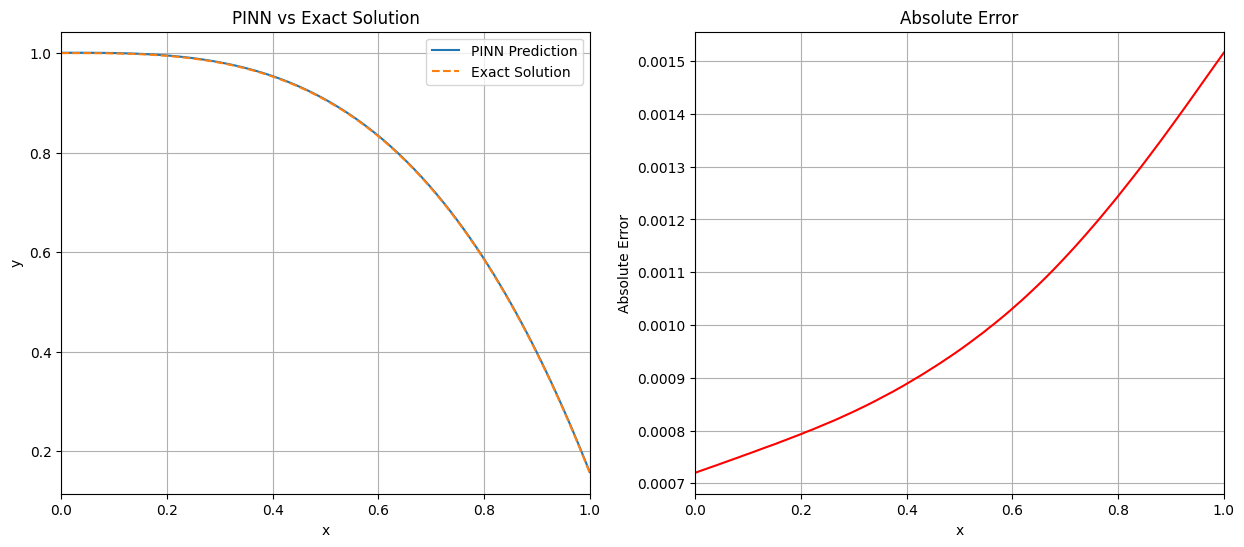

In [18]:
model = test_and_plot(params_test, ode_residual_5extra, length='standard', save_model=True, ic_dx=[0.0, 0.0], ic_dx2=[0.0, 0.0])
ode_accuracy_test(model, y_func_5extra)

The error is expectedly higher, but still quite low. The time, however, is almost the same as for the previous 3rd order ODE.
Now, we test our PINN model on a 1st order ODE without an analytical solution.

In [19]:
def ode_residual_comp(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: dy/dx + y^3 - x = 0
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return y_pred_x + y_pred**3 - x

ode_comp = Eq(diff(y, x) + y**3 - x, 0)
display(Math(latex(ode_comp)))

# no analytical solution available

<IPython.core.display.Math object>

100%|██████████| 10000/10000 [00:22<00:00, 446.32it/s]


Training completed in 22.41s


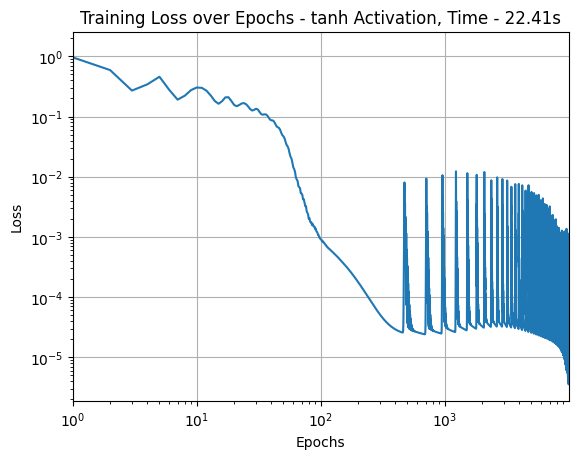

In [20]:
test_and_plot(params_test, ode_residual_comp, length='standard')

As a final consistency check, we intentionally provide wrong initial conditions to see how the PINN model behaves. 

In [21]:
def ode_residual_wrong_ic(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: dy/dx + y/x - 2x = 0 with wrong initial condition
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return y_pred_x + y_pred / x - 2 * x

ode_wrong_ic = Eq(diff(y, x) + y / x - 2*x, 0)
display(Math(latex(ode_wrong_ic)))

<IPython.core.display.Math object>

100%|██████████| 10000/10000 [00:24<00:00, 402.78it/s]


Training completed in 24.83s


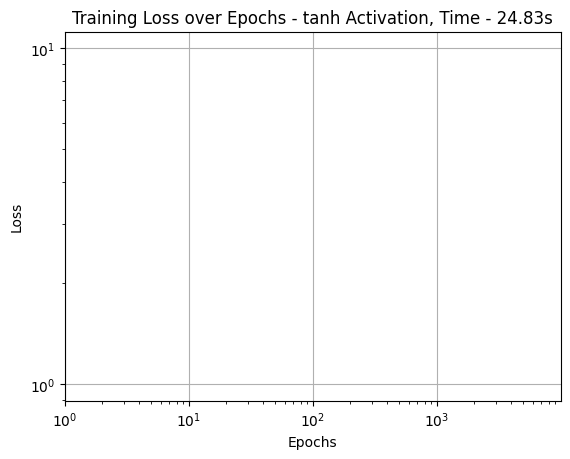

In [22]:
test_and_plot(params_test, ode_residual_wrong_ic, length='standard', savefig='act-sin_ne-100-stand-ode4.png')

In [23]:
def ode_residual_wrong_ic2(x: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    # Example: d2y/dx2 + y/x - 2x = 0 with wrong initial condition
    y_pred_x = torch.autograd.grad(y_pred, x, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    y_pred_xx = torch.autograd.grad(y_pred_x, x, grad_outputs=torch.ones_like(y_pred_x), create_graph=True)[0]
    return y_pred_xx + y_pred / x - 2 * x

ode_wrong_ic2 = Eq(diff(y, x, x) + y / x - 2*x, 0)
display(Math(latex(ode_wrong_ic2)))

<IPython.core.display.Math object>

100%|██████████| 10000/10000 [00:40<00:00, 248.74it/s]


Training completed in 40.20s


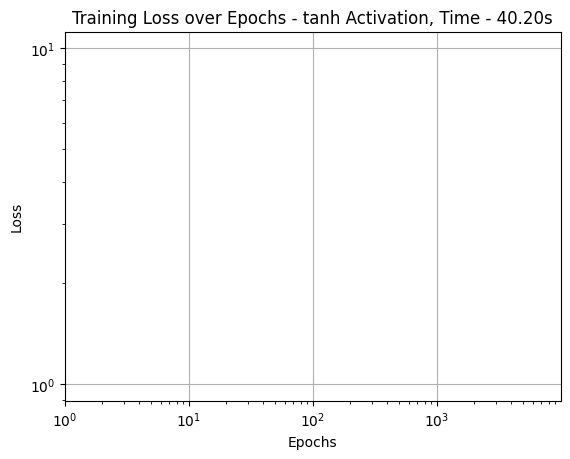

In [24]:
test_and_plot(params_test, ode_residual_wrong_ic2, length='standard', savefig='act-sin_ne-100-stand-ode4.png')

The training does go through, but the resulting loss is filled with `nan` and `inf` values, which is expected since the initial conditions are inconsistent with the ODE. The PINN model is not able to produce a meaningful result in this case.

# TEST 1

Loss and time behavior for different activations and number of neurons in hidden layers.
Test configurations:
- Activations: `Tanh`, `Sin`, `Sigmoid`, `ReLU`, `Softplus`
- Number of neurons in hidden layers: `20`, `50`, `100`
- Number of epochs: `10000`

The motivation behind this test is to examine the effect of the number of neurons on the performance of the PINN model. Specifically, we want to see if the total accuracy increases with the number of neurons, and what is the computational cost of this increase. We also want to see how different activation functions behave in this context.

In [25]:
# test configurations:
act_list_1 = ['tanh', 'sin', 'sigmoid', 'relu', 'softplus']
neuron_list_1 = [20, 50, 100]

def test_1(activation: str, neurons: int, length: str = 'standard'):
    params = pinn.TrainParams(
        optimizer=optim.Adam,
        activation=activation,
        ic=[0.0, 1.0],  # Example: y(0) = 1
        layers=[1, neurons, neurons, neurons, 1],
    )
    test_and_plot(params, ode_residual, length=length, savefig=f'act-{activation}_ne-{neurons}-stand.png')

100%|██████████| 10000/10000 [00:16<00:00, 623.84it/s]


Training completed in 16.03s


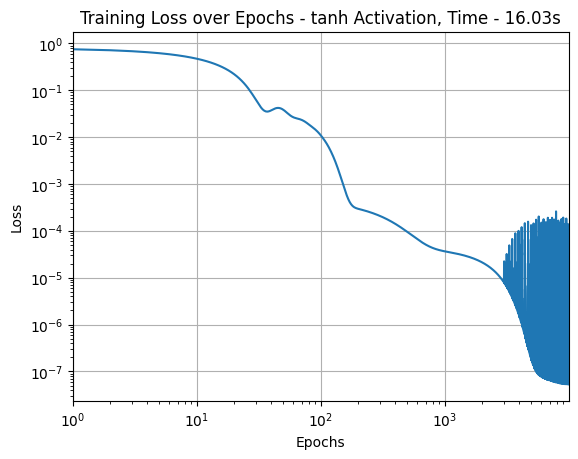

100%|██████████| 10000/10000 [00:17<00:00, 560.84it/s]


Training completed in 17.84s


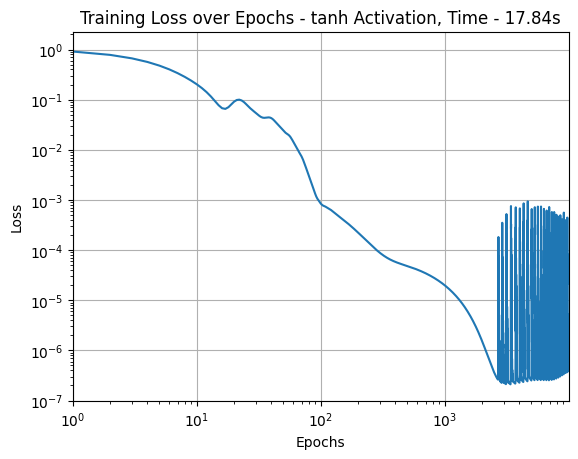

100%|██████████| 10000/10000 [00:21<00:00, 457.87it/s]


Training completed in 21.85s


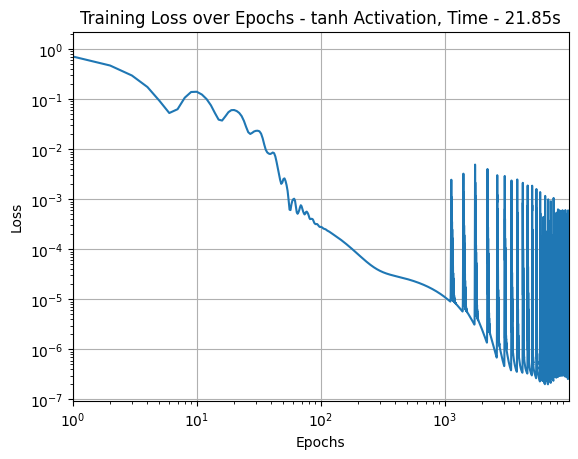

100%|██████████| 10000/10000 [00:16<00:00, 606.26it/s]


Training completed in 16.50s


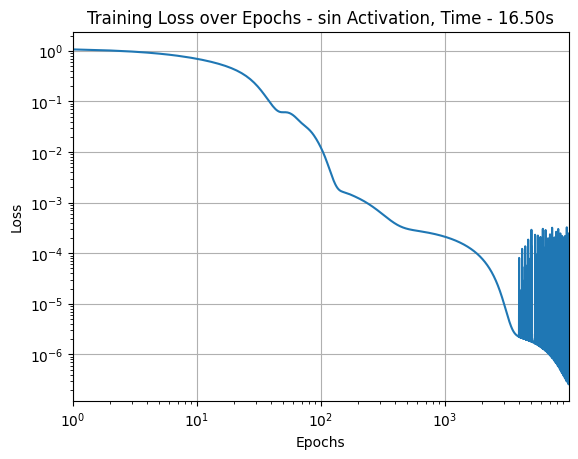

100%|██████████| 10000/10000 [00:18<00:00, 533.09it/s]


Training completed in 18.76s


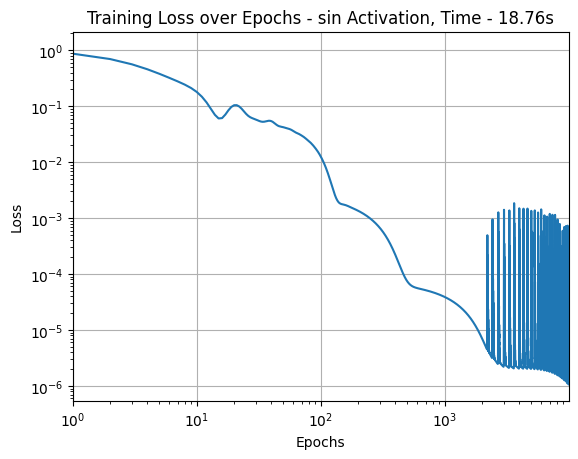

100%|██████████| 10000/10000 [00:23<00:00, 422.34it/s]


Training completed in 23.68s


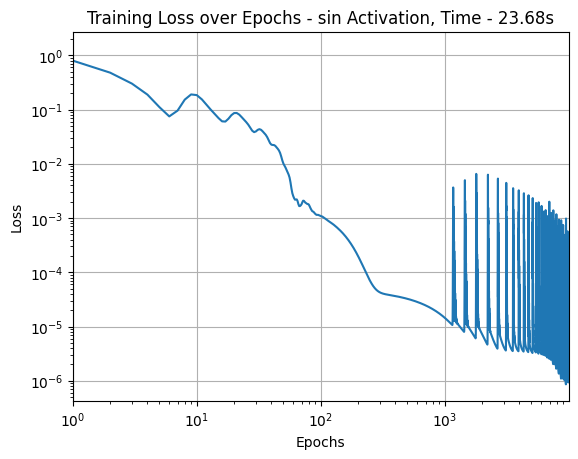

100%|██████████| 10000/10000 [00:16<00:00, 623.22it/s]


Training completed in 16.05s


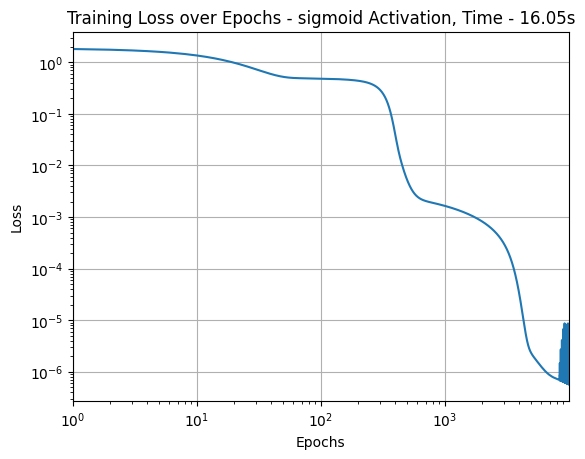

100%|██████████| 10000/10000 [00:17<00:00, 576.77it/s]


Training completed in 17.34s


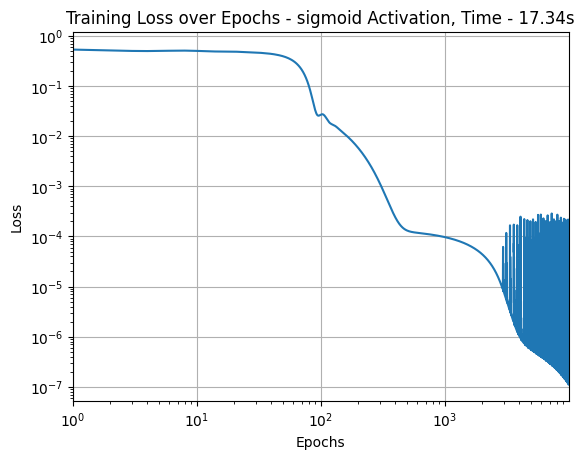

100%|██████████| 10000/10000 [00:21<00:00, 474.32it/s]


Training completed in 21.09s


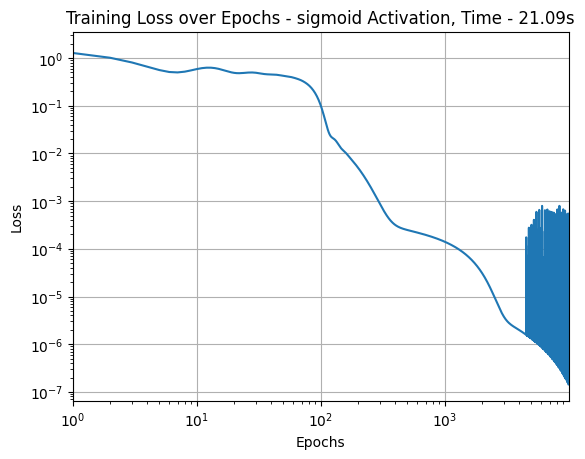

100%|██████████| 10000/10000 [00:15<00:00, 646.33it/s]


Training completed in 15.48s


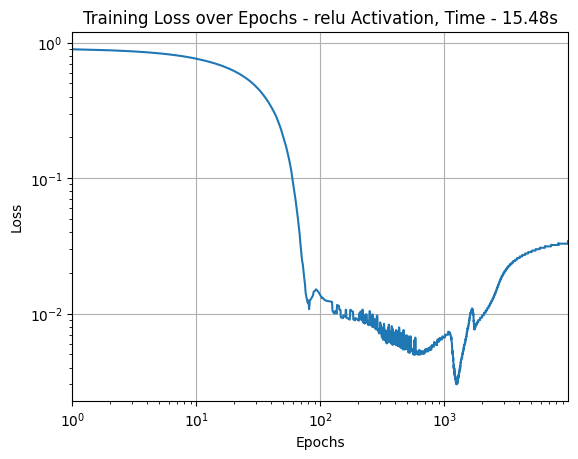

100%|██████████| 10000/10000 [00:16<00:00, 588.75it/s]


Training completed in 16.99s


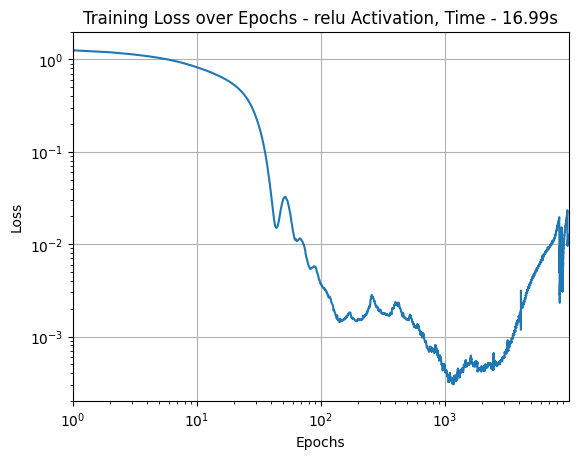

100%|██████████| 10000/10000 [00:20<00:00, 476.22it/s]


Training completed in 21.00s


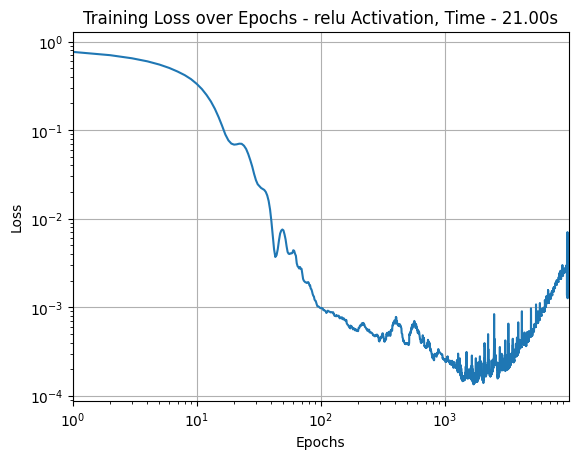

100%|██████████| 10000/10000 [00:16<00:00, 591.37it/s]


Training completed in 16.92s


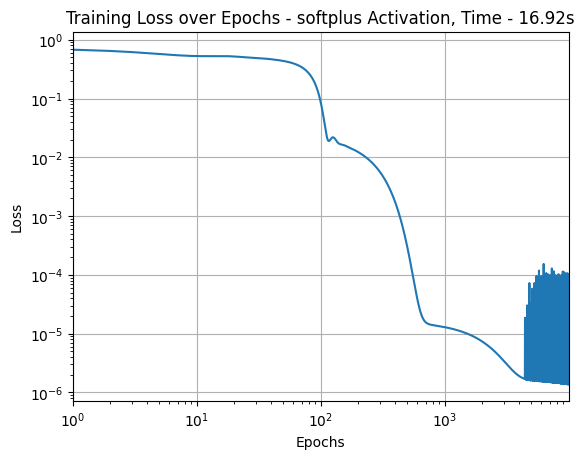

100%|██████████| 10000/10000 [00:19<00:00, 505.99it/s]


Training completed in 19.77s


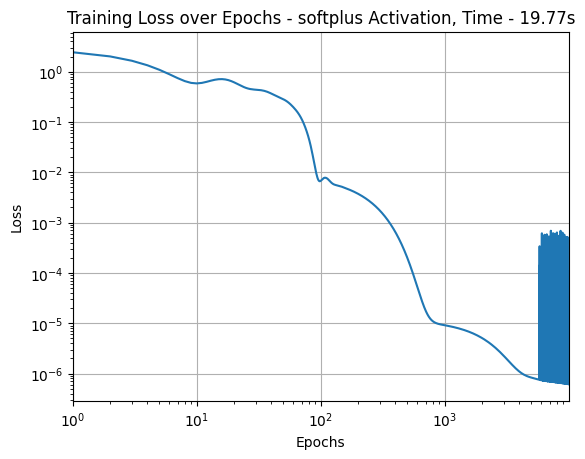

100%|██████████| 10000/10000 [00:24<00:00, 414.17it/s]


Training completed in 24.15s


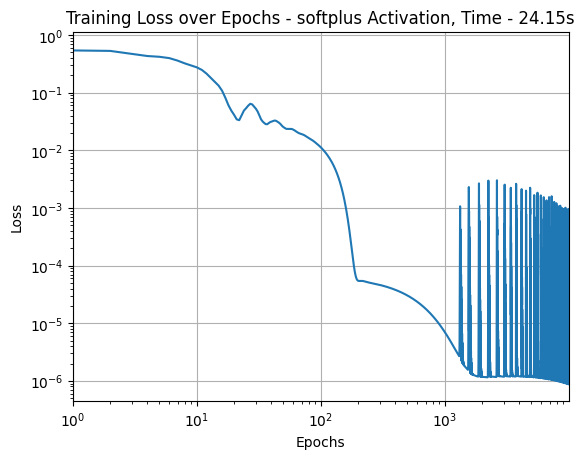

In [26]:
for act in act_list_1:
    for ne in neuron_list_1:
        test_1(act, ne)

## Conclusions

- Although the final accuracy does not increase significantly with the number of neurons, the convergence is generally faster with more neurons. This allows for achieving a desired accuracy in fewer epochs, for example, in the next subtest, we will run the training for 2500 epochs instead of 10000 and test it.
- The time increases with the number of neurons, but not drastically. For example, going from 20 to 100 neurons increases the time by about 6s on average. Given that the convergence is faster, the user might need to run fewer epochs, which can offset the increased time per epoch.
- Most activation functions perform similarly, with `Tanh` and `Sigmoid` showing slightly better accuracy ($10^{-7}$). `Sin` and `Softplus` are also quite good ($10^{-6}$). The `ReLU` activation function shows the worst performance in this test, with accuracy around $10^{-3}$. In addition, this function tends to lose convergence after some number of epochs, which is not great for PINN model, as it is expected to work with a wide range of problems without much tuning. The `ReLU` function is the fastest, but the accuracy is not satisfactory.
- The best function in terms of accuracy and time const is `Sigmoid`, which is faster than `Tanh` and achieves similar accuracy.

# TEST 1.1 - Flash version of Test 1

Number of epochs: `2500`

100%|██████████| 2500/2500 [00:04<00:00, 616.42it/s]


Training completed in 4.06s


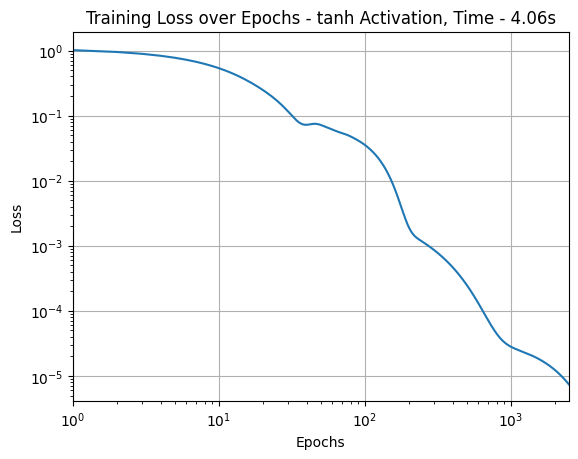

100%|██████████| 2500/2500 [00:04<00:00, 566.56it/s]


Training completed in 4.42s


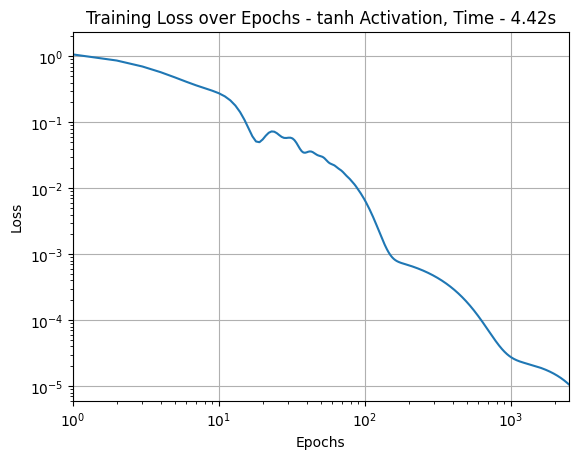

100%|██████████| 2500/2500 [00:05<00:00, 454.60it/s]


Training completed in 5.50s


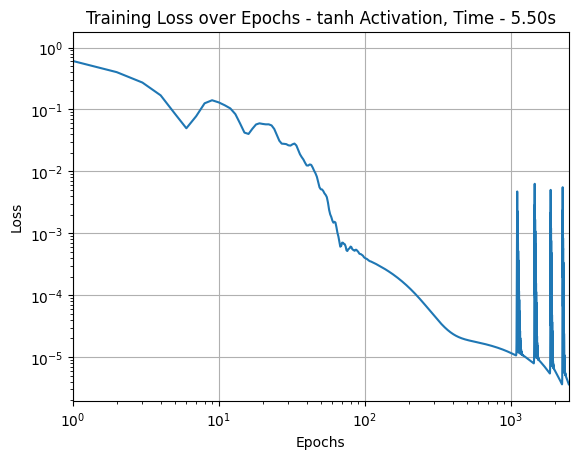

100%|██████████| 2500/2500 [00:04<00:00, 608.29it/s]


Training completed in 4.11s


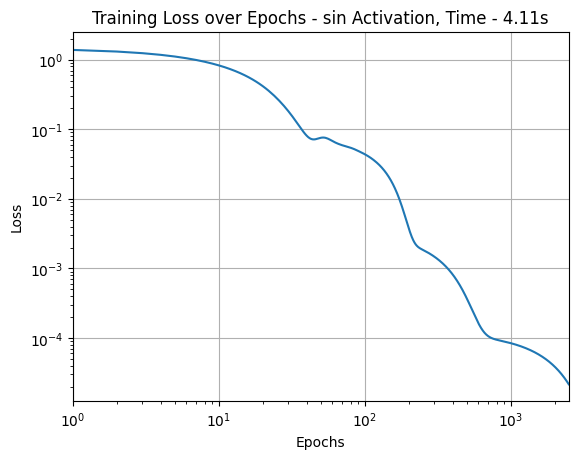

100%|██████████| 2500/2500 [00:04<00:00, 534.78it/s]


Training completed in 4.68s


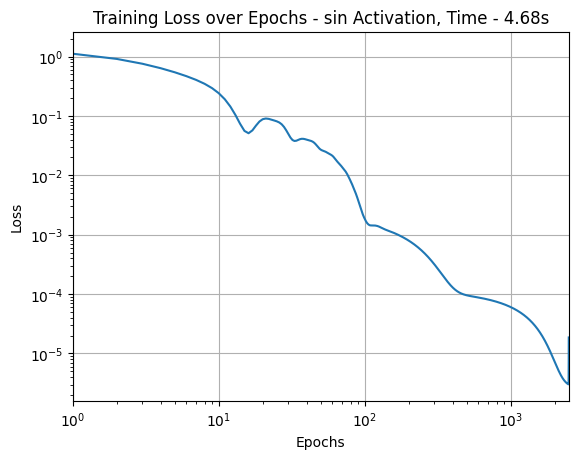

100%|██████████| 2500/2500 [00:05<00:00, 423.29it/s]


Training completed in 5.91s


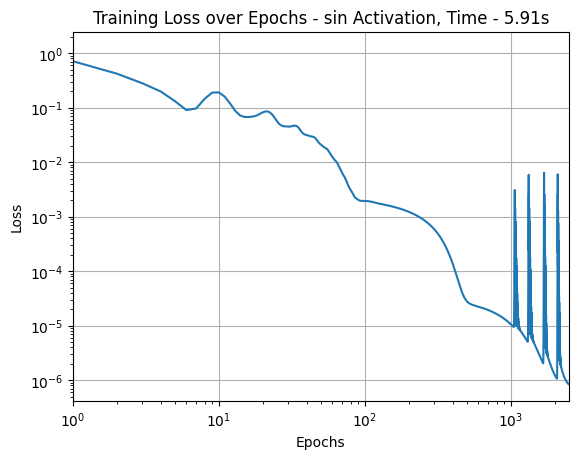

100%|██████████| 2500/2500 [00:03<00:00, 627.64it/s]


Training completed in 3.99s


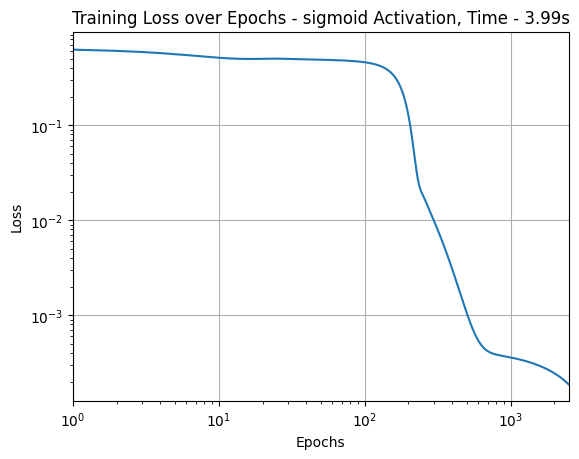

100%|██████████| 2500/2500 [00:04<00:00, 576.05it/s]


Training completed in 4.34s


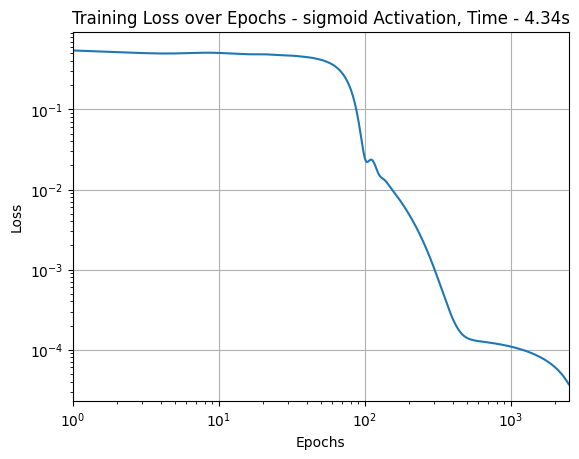

100%|██████████| 2500/2500 [00:05<00:00, 475.23it/s]


Training completed in 5.27s


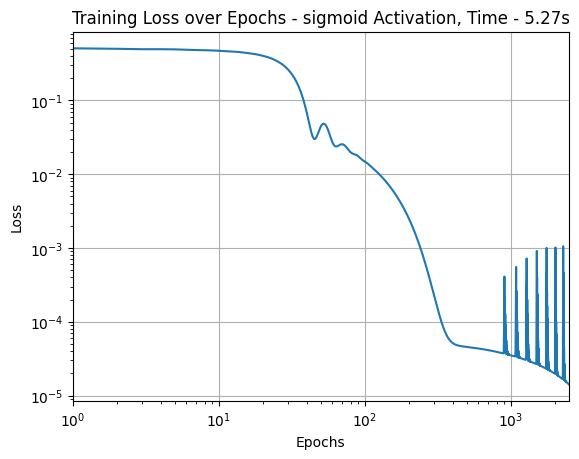

100%|██████████| 2500/2500 [00:03<00:00, 636.40it/s]


Training completed in 3.93s


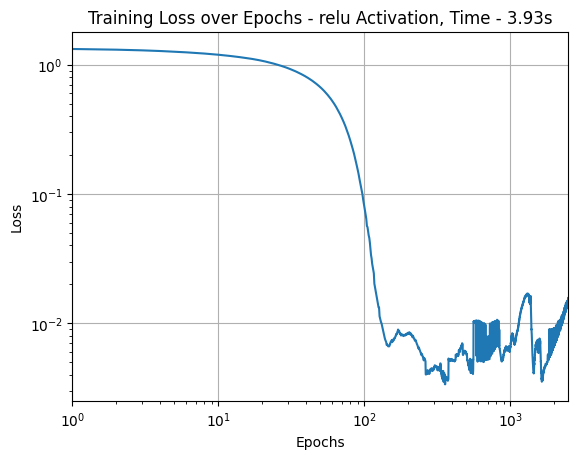

100%|██████████| 2500/2500 [00:04<00:00, 589.57it/s]


Training completed in 4.25s


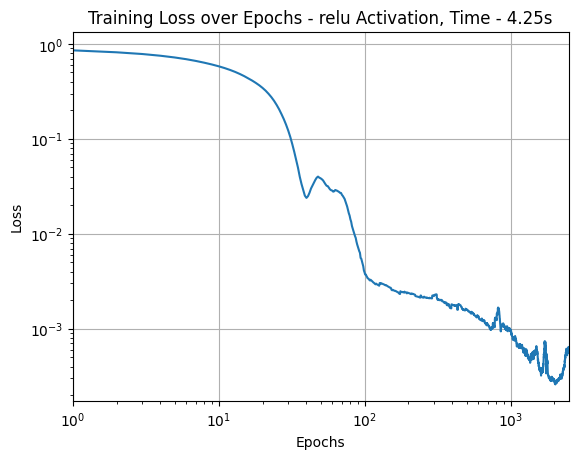

100%|██████████| 2500/2500 [00:05<00:00, 474.80it/s]


Training completed in 5.27s


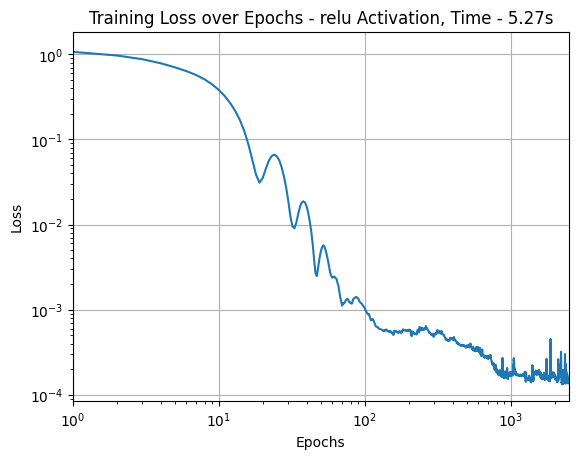

100%|██████████| 2500/2500 [00:04<00:00, 590.10it/s]


Training completed in 4.24s


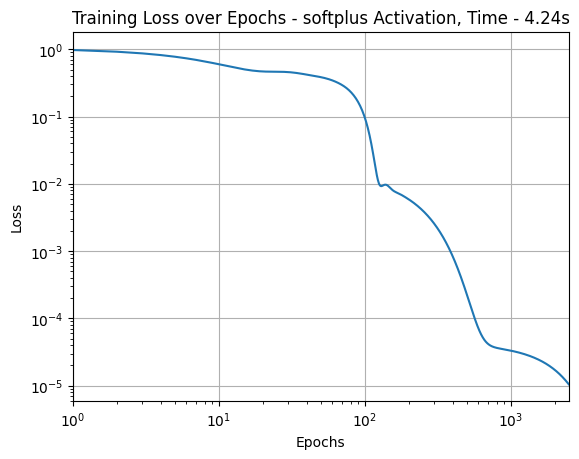

100%|██████████| 2500/2500 [00:04<00:00, 522.02it/s]


Training completed in 4.79s


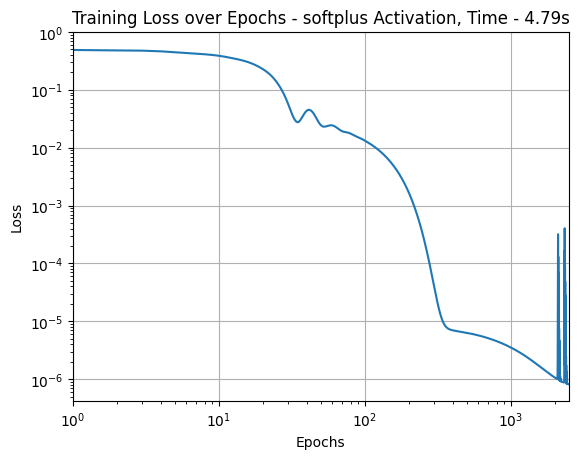

100%|██████████| 2500/2500 [00:06<00:00, 414.43it/s]


Training completed in 6.03s


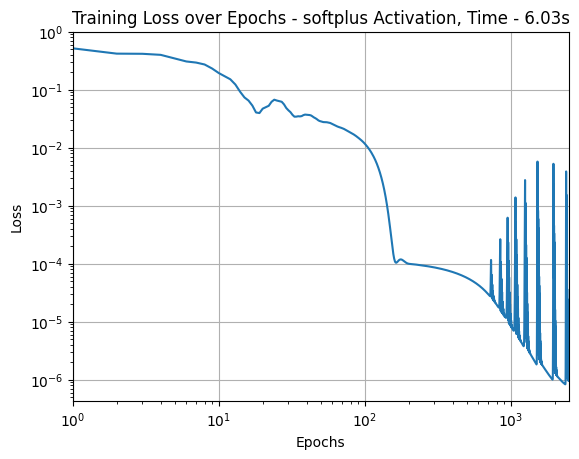

In [27]:
for act in act_list_1:
    for ne in neuron_list_1:
        test_1(act, ne, length='flash')

## Conclusions 

On the `flash` version of the test, it is more apparent that the number of neurons increases the convergence speed, while the time per epoch does not increase significantly. Here, `Tanh`, `Sin`, and `ReLU` reached the accuracy of $10^{-3}$ in just 100 epochs with 100 neurons, while with 20 neurons, `ReLU` did not reach this accuracy even after 2500 epochs.

# TEST 2 

Loss and time behavior depending on the activation function and optimizer.

Test configurations:
- Activations: `Tanh`, `Sin`, `Sigmoid`, `ReLU`, `Softplus`
- Optimizers: `Adam`, `SGD`, `RMSprop`, `RAdam`, `Adadelta`
- Number of neurons in hidden layers: `50`
- Number of epochs: `30000` - will track time every 100 epochs

The motivation behind this test is to examine how different optimization algorithms in combination with different activation functions affect the performance of the PINN model. We also want to see if certain combinations lead to non-linear time increase. 

In [28]:
def test_2(activation: str, optimizer: optim.Optimizer = optim.Adam, plot: bool = True):
    params = pinn.TrainParams(
        optimizer=optimizer,
        activation=activation,
        ic=[0.0, 1.0],  # Example: y(0) = 1
        layers=[1, 50, 50, 50, 1],
    )
    pinn.train(params, ode_residual, length='long', save_results=True)

    if not plot:
        return params
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].plot(params.epochs_long, params.time_long)
    axs[0].set_xlim(1, params.epochs_long[-1])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Time (s)')
    axs[0].set_title(f'Time over Epochs')
    axs[0].grid(True)

    axs[1].loglog(params.epochs, params.loss)
    axs[1].set_xlim(1, params.epochs[-1])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss over Epochs')
    axs[1].grid(True)

    fig.suptitle(f'Activation: {activation}, Optimizer: {optimizer.__name__}, Time - {params.time:.2f}s')
    plt.savefig(f'act-{activation}_opt-{optimizer.__name__}-long.png')
    plt.show()

100%|██████████| 30000/30000 [00:53<00:00, 565.33it/s]


Training completed in 53.07s


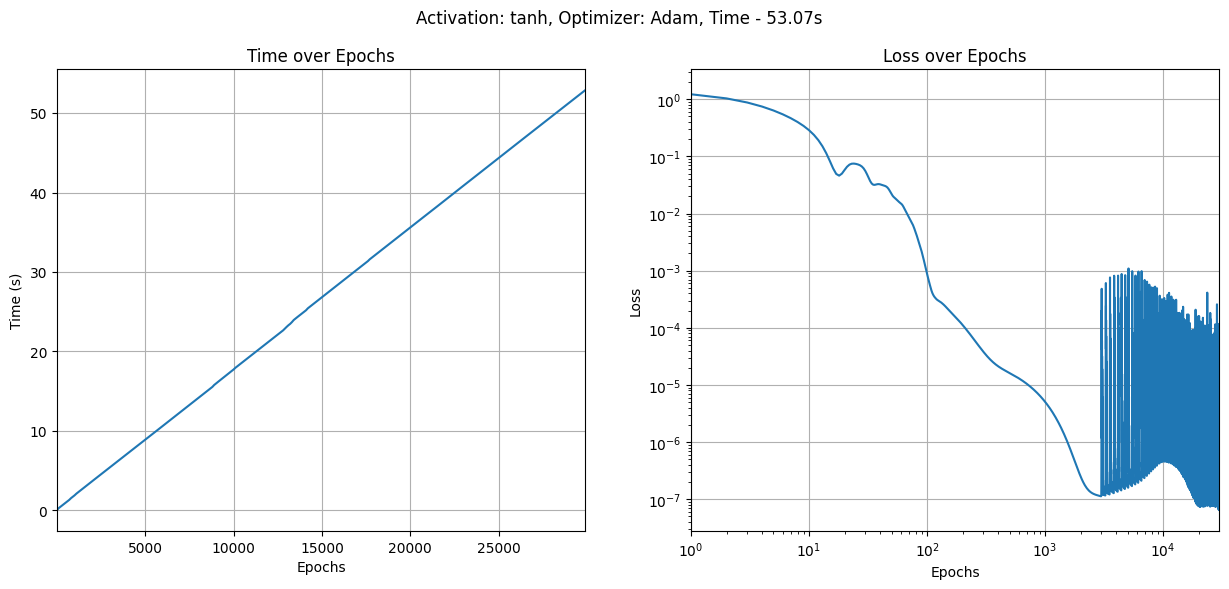

100%|██████████| 30000/30000 [00:41<00:00, 721.00it/s]


Training completed in 41.62s


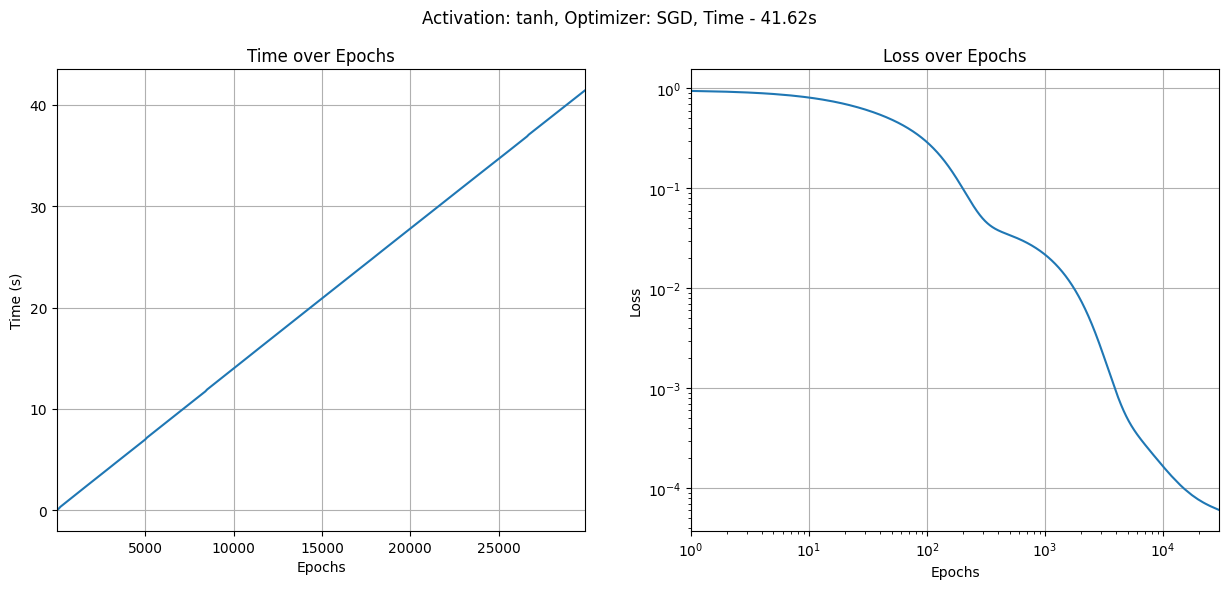

100%|██████████| 30000/30000 [00:48<00:00, 615.89it/s]


Training completed in 48.71s


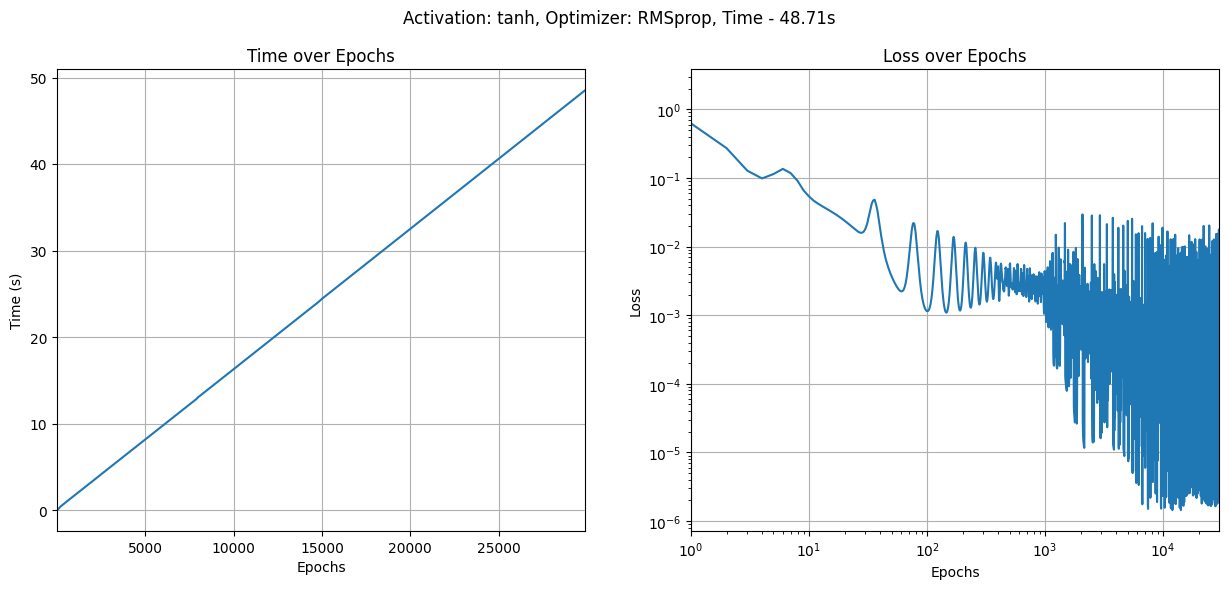

100%|██████████| 30000/30000 [00:59<00:00, 505.33it/s]


Training completed in 59.37s


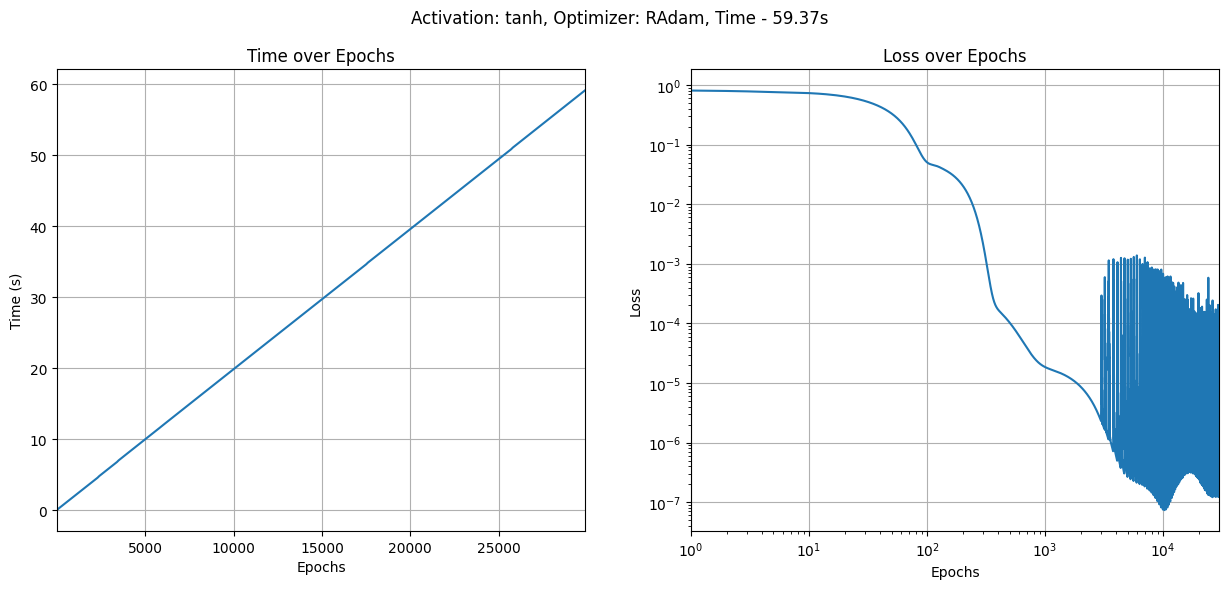

100%|██████████| 30000/30000 [00:53<00:00, 558.07it/s]


Training completed in 53.76s


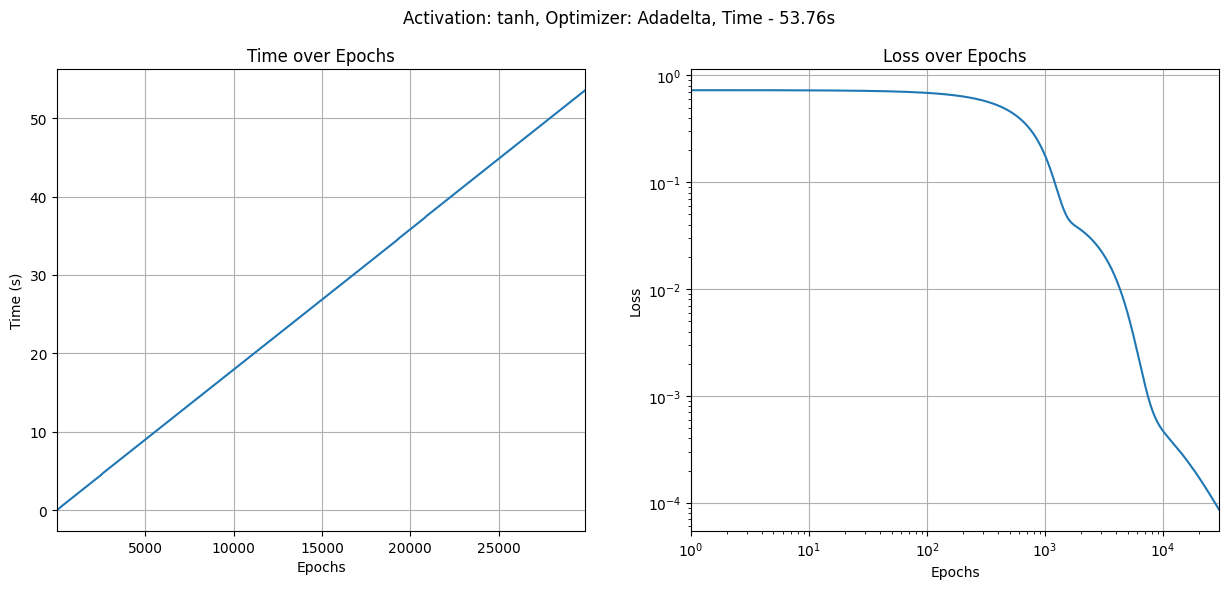

100%|██████████| 30000/30000 [00:55<00:00, 539.49it/s]


Training completed in 55.61s


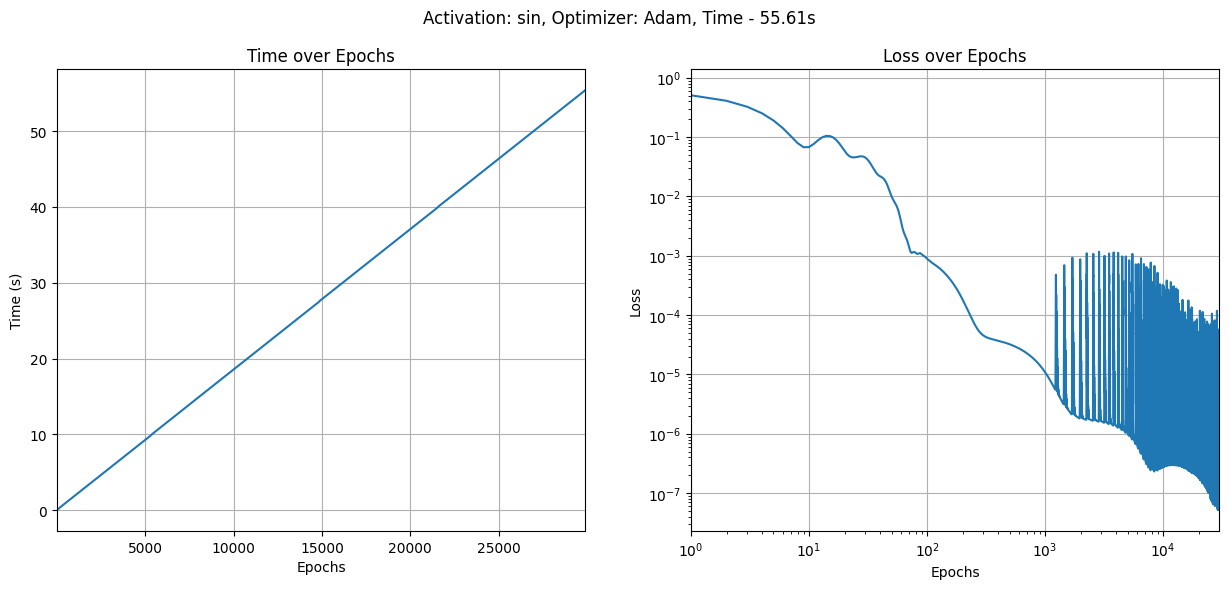

100%|██████████| 30000/30000 [00:44<00:00, 670.29it/s]


Training completed in 44.77s


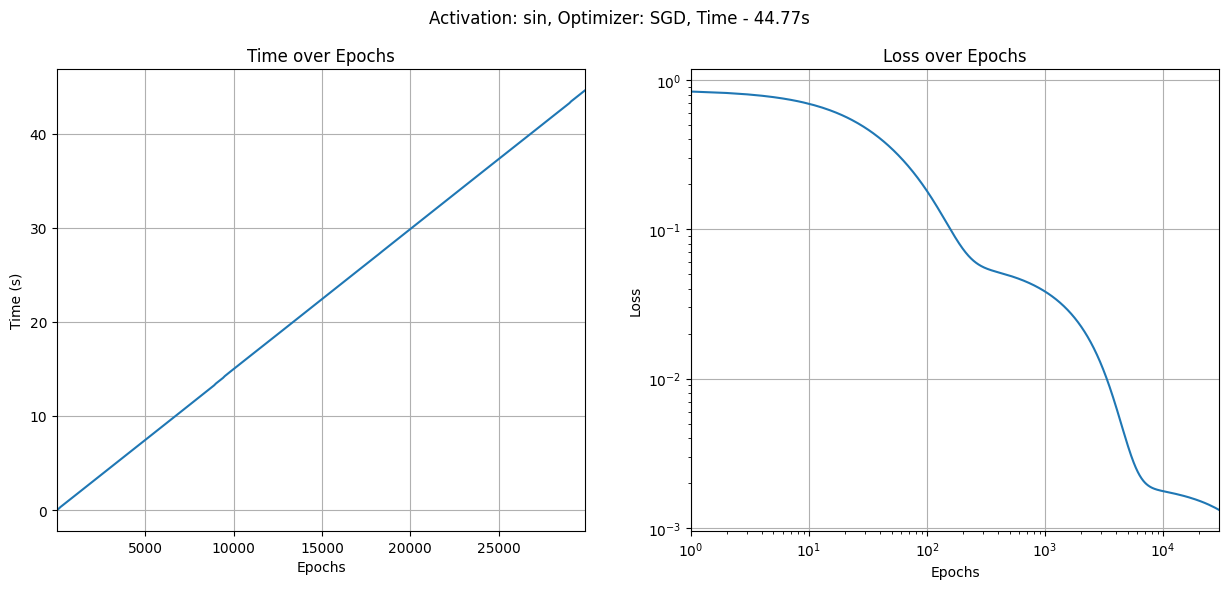

100%|██████████| 30000/30000 [00:52<00:00, 575.04it/s]


Training completed in 52.18s


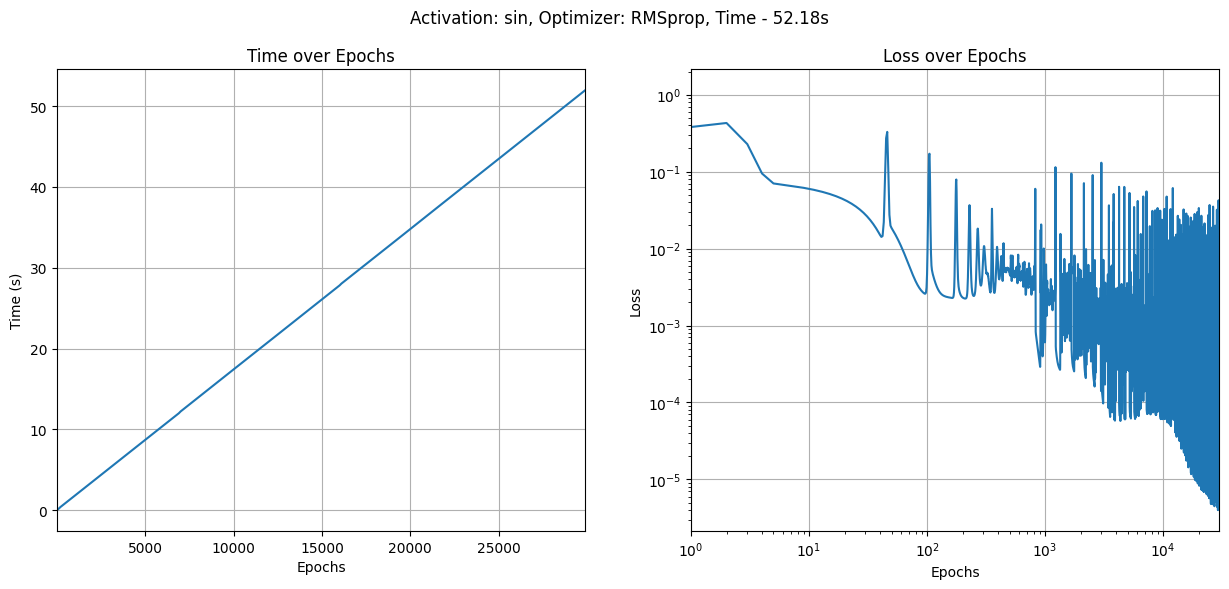

100%|██████████| 30000/30000 [01:02<00:00, 477.13it/s]


Training completed in 62.89s


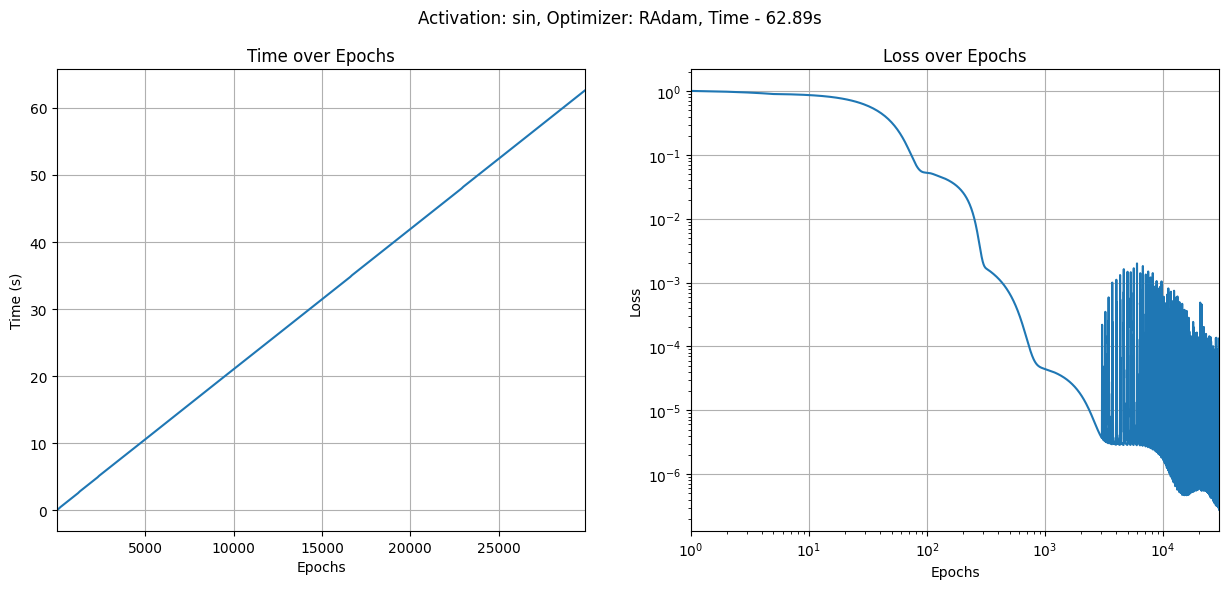

100%|██████████| 30000/30000 [00:57<00:00, 525.08it/s]


Training completed in 57.14s


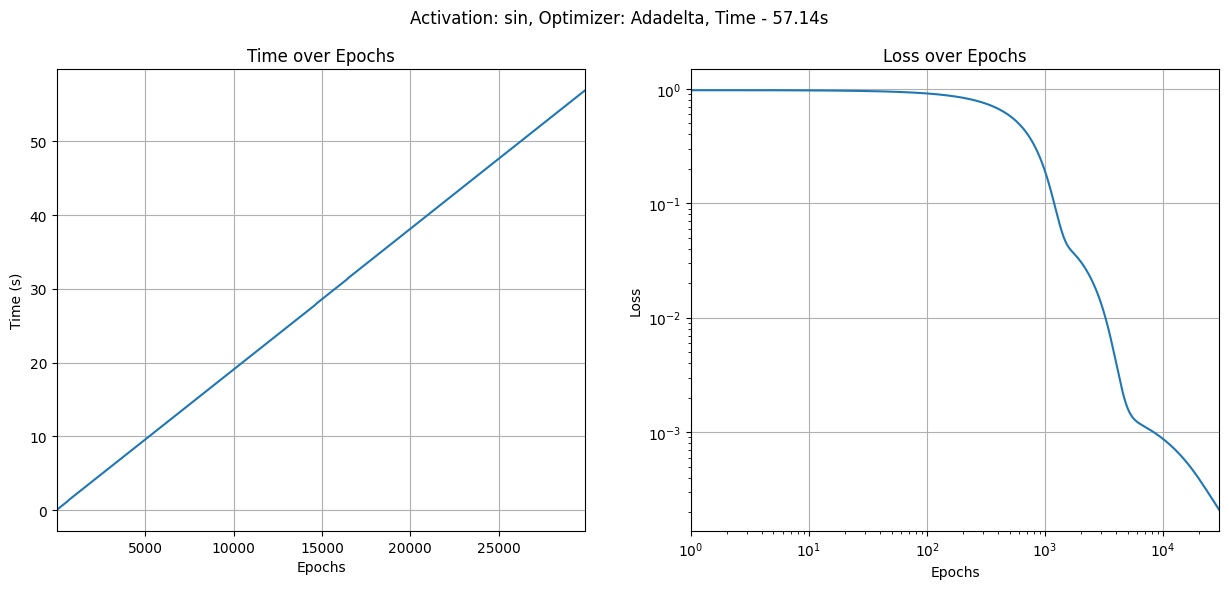

100%|██████████| 30000/30000 [00:51<00:00, 579.28it/s]


Training completed in 51.79s


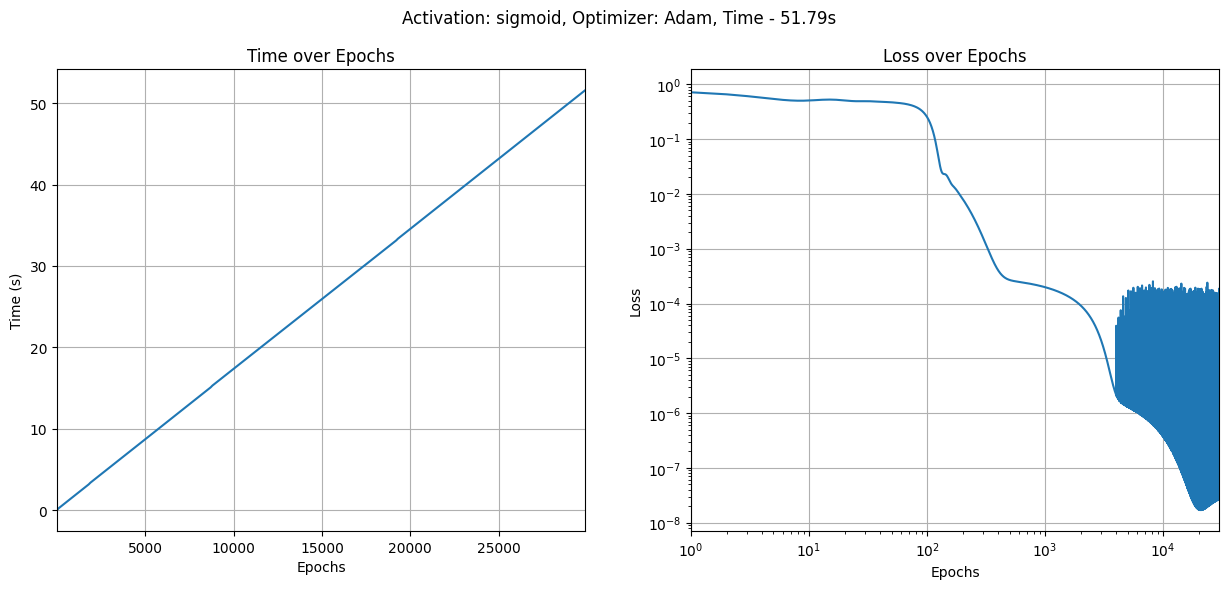

100%|██████████| 30000/30000 [00:40<00:00, 735.83it/s]


Training completed in 40.77s


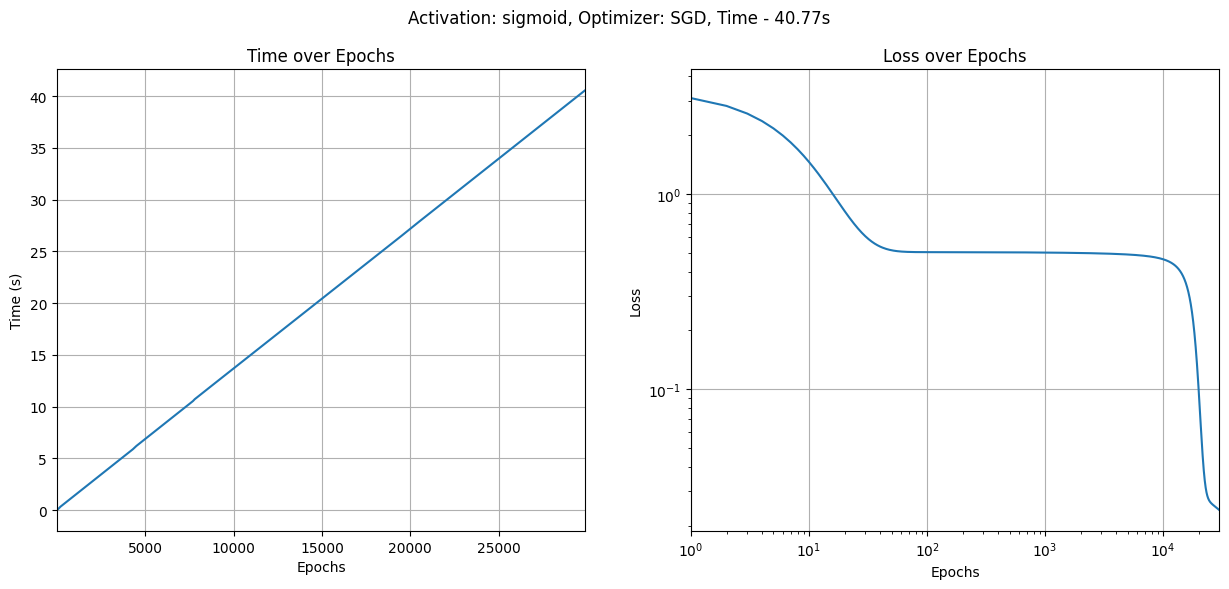

100%|██████████| 30000/30000 [00:48<00:00, 622.15it/s]


Training completed in 48.22s


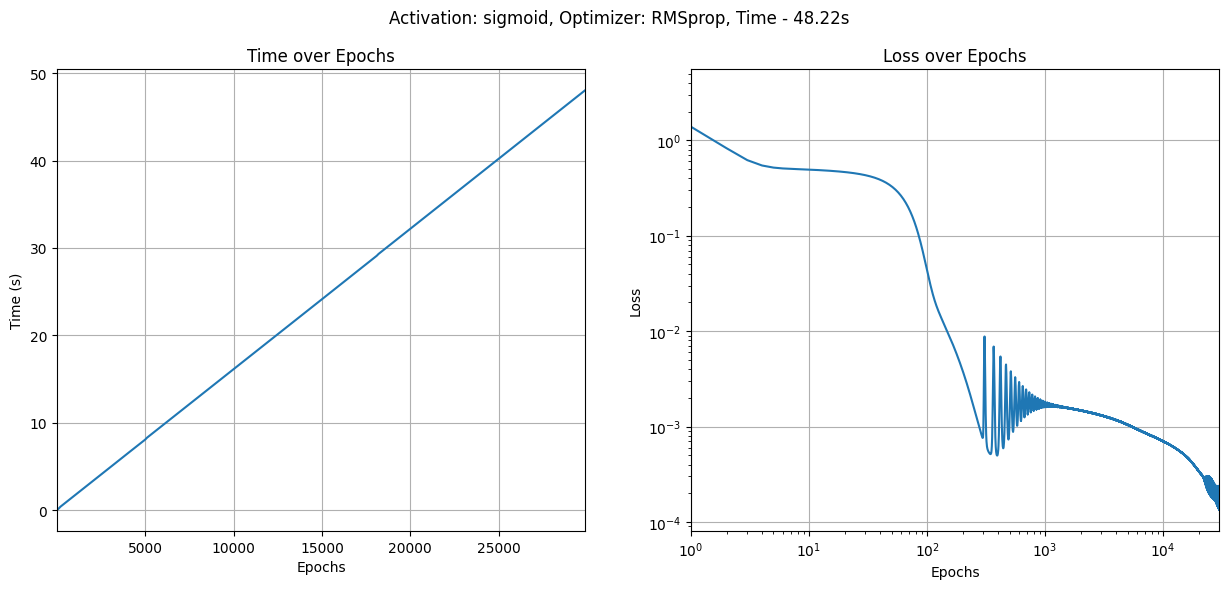

100%|██████████| 30000/30000 [00:58<00:00, 510.29it/s]


Training completed in 58.79s


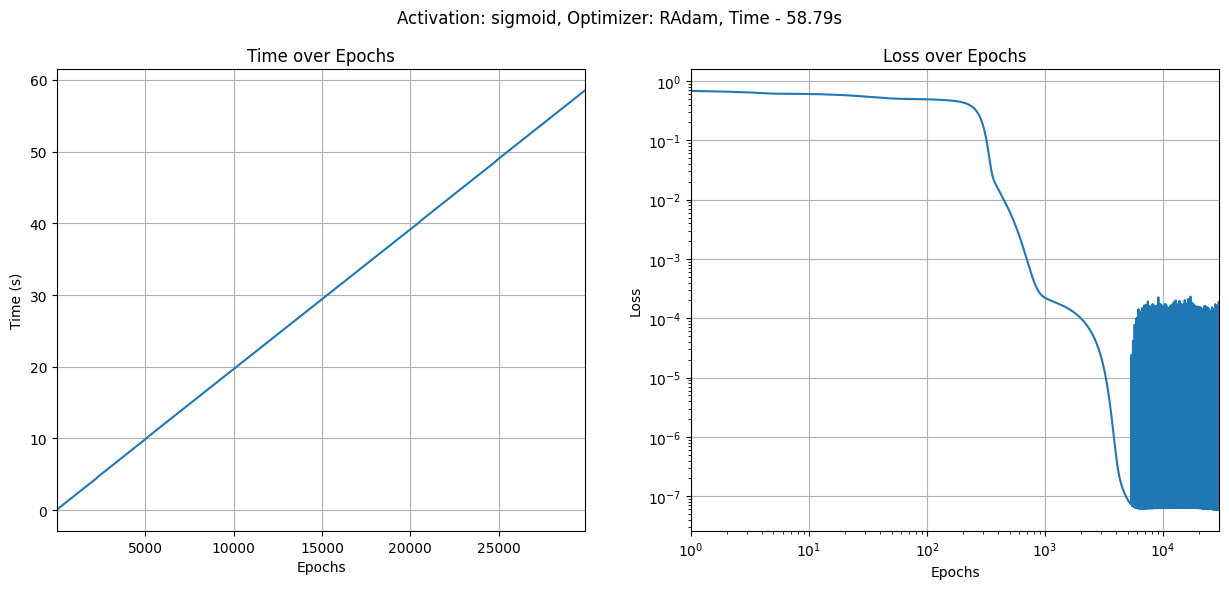

100%|██████████| 30000/30000 [00:53<00:00, 564.19it/s]


Training completed in 53.18s


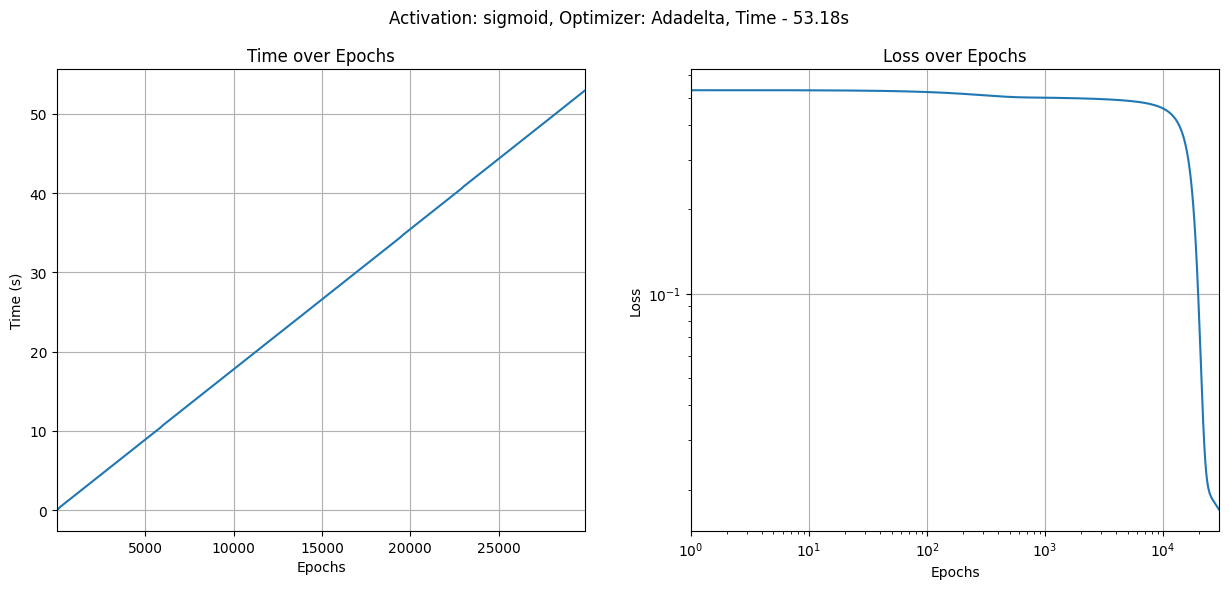

100%|██████████| 30000/30000 [00:50<00:00, 594.50it/s]


Training completed in 50.47s


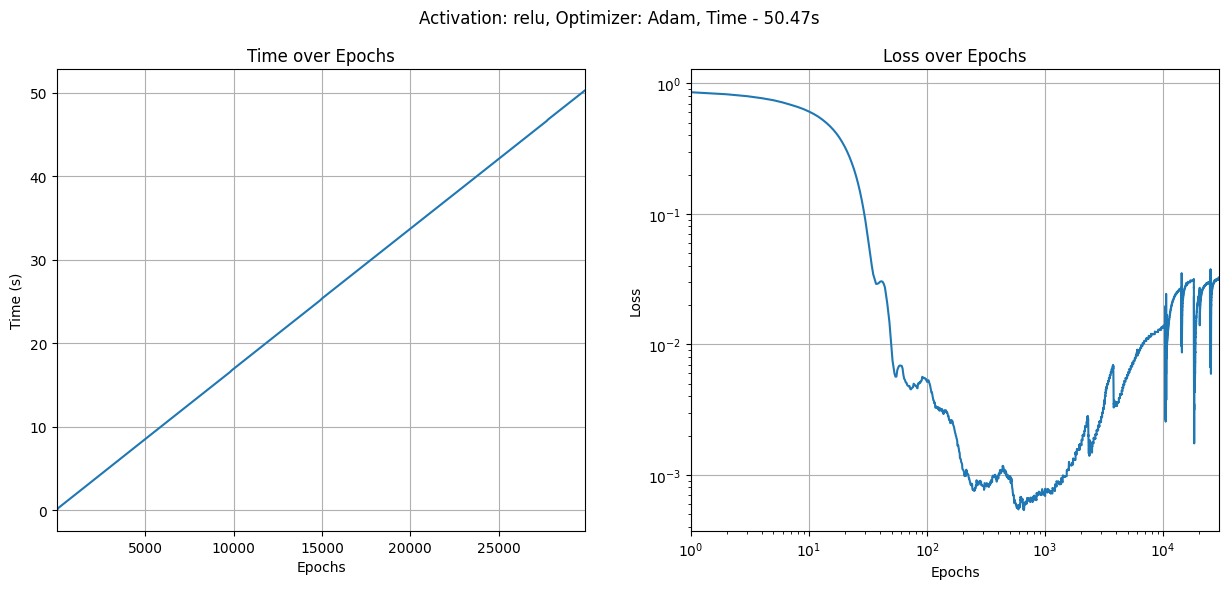

100%|██████████| 30000/30000 [00:39<00:00, 766.18it/s]


Training completed in 39.16s


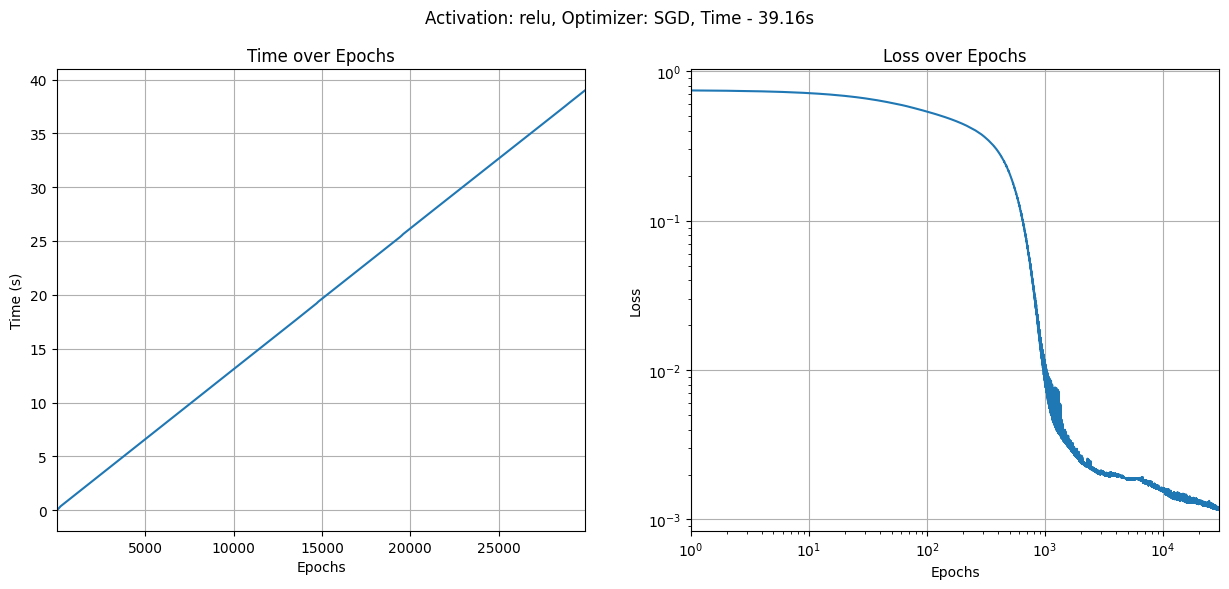

100%|██████████| 30000/30000 [00:48<00:00, 621.67it/s]


Training completed in 48.27s


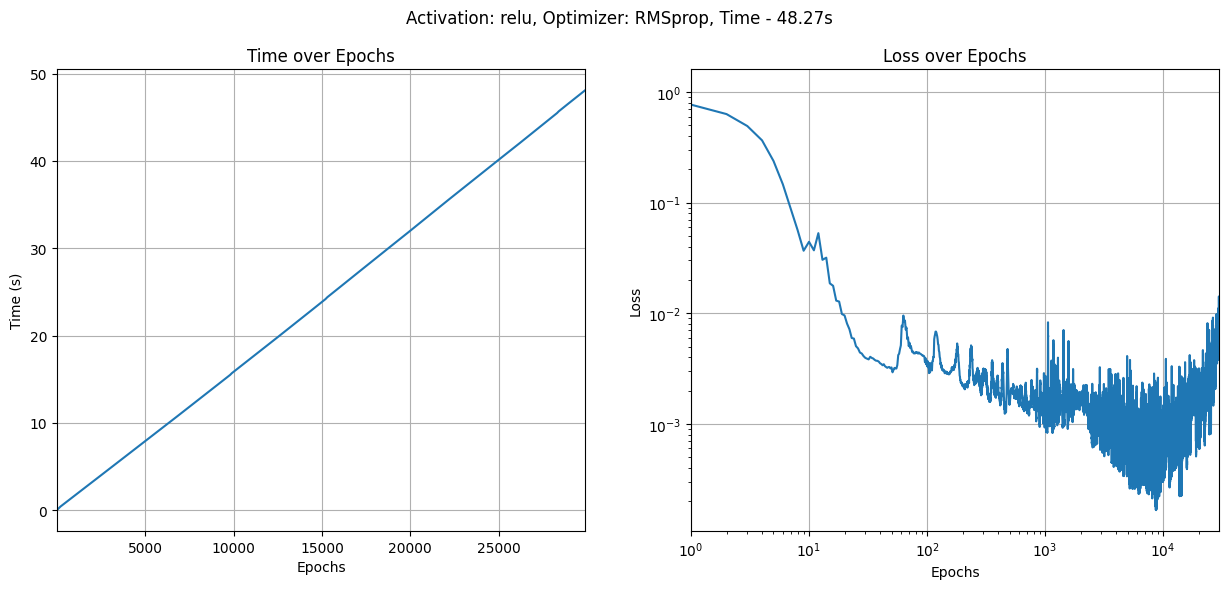

100%|██████████| 30000/30000 [00:58<00:00, 515.32it/s]


Training completed in 58.22s


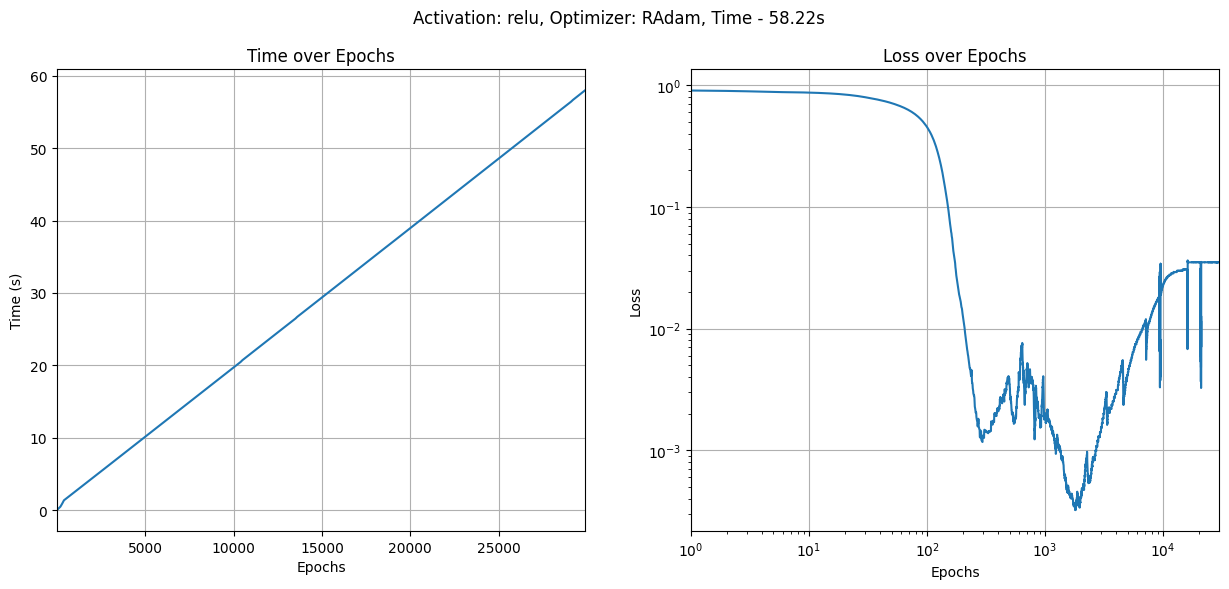

100%|██████████| 30000/30000 [00:51<00:00, 580.72it/s]


Training completed in 51.67s


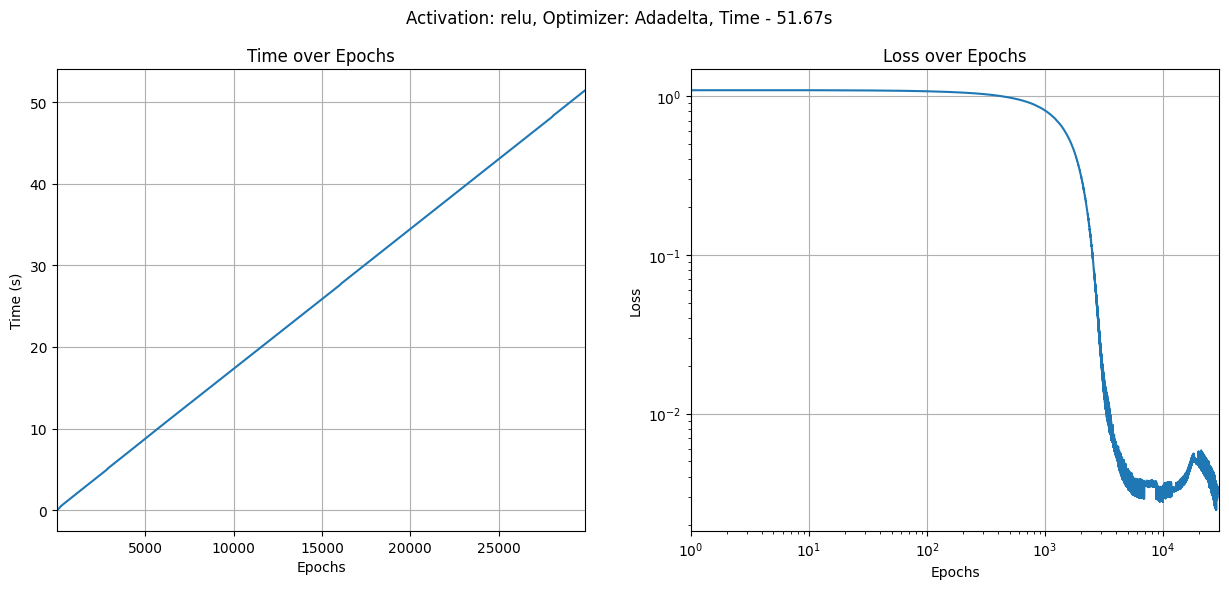

100%|██████████| 30000/30000 [00:57<00:00, 523.57it/s]


Training completed in 57.30s


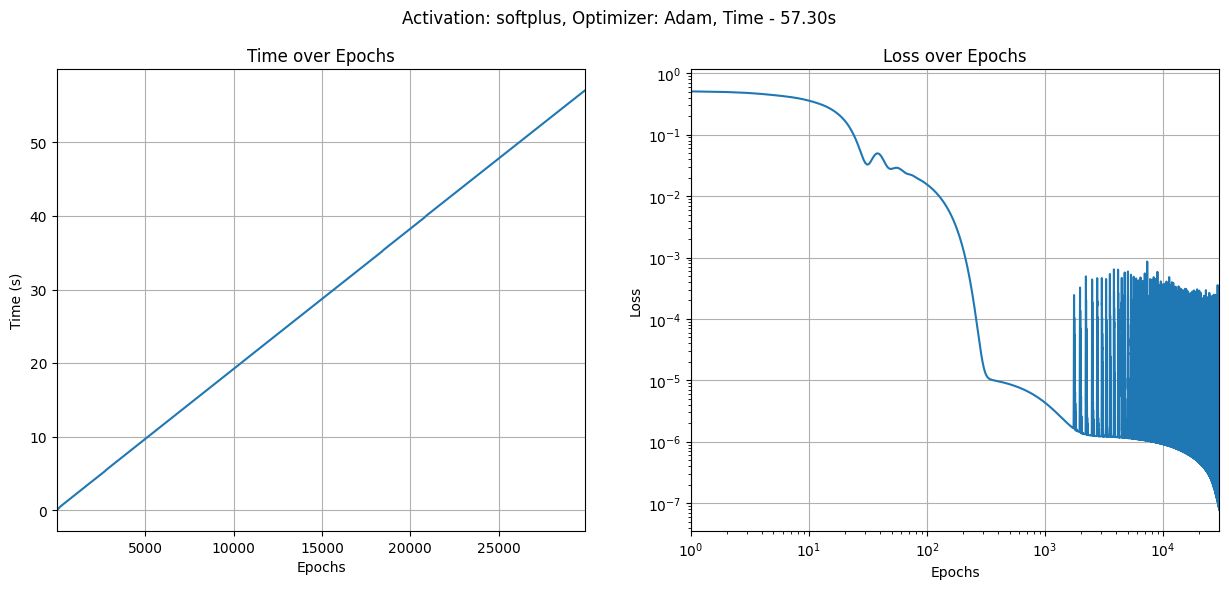

100%|██████████| 30000/30000 [00:46<00:00, 647.98it/s]


Training completed in 46.31s


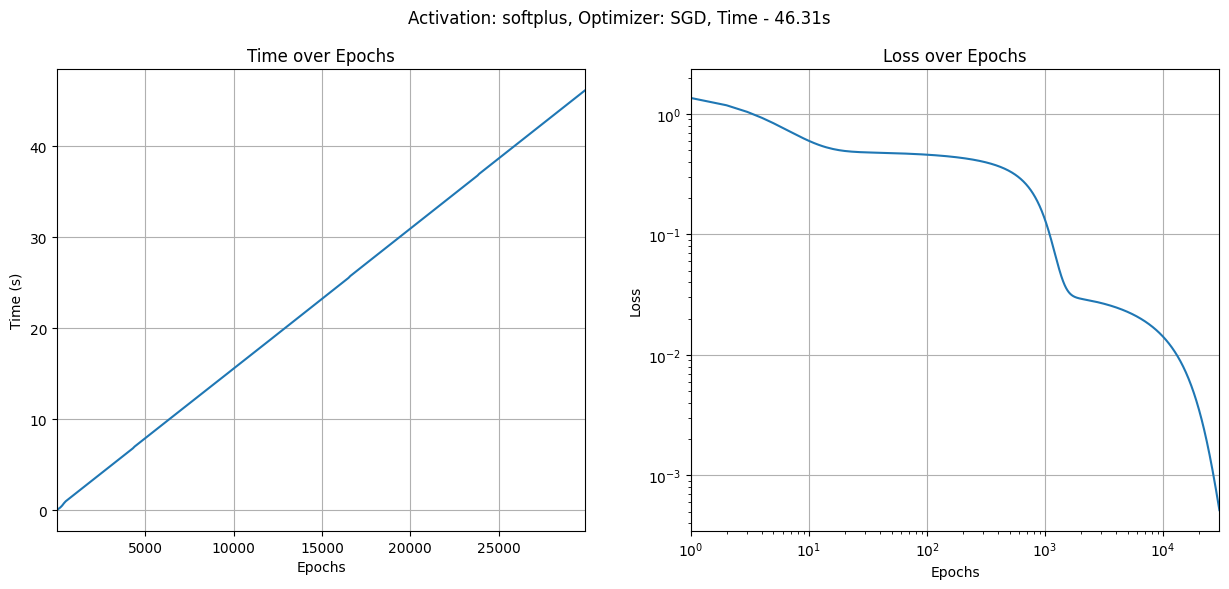

100%|██████████| 30000/30000 [00:53<00:00, 560.93it/s]


Training completed in 53.49s


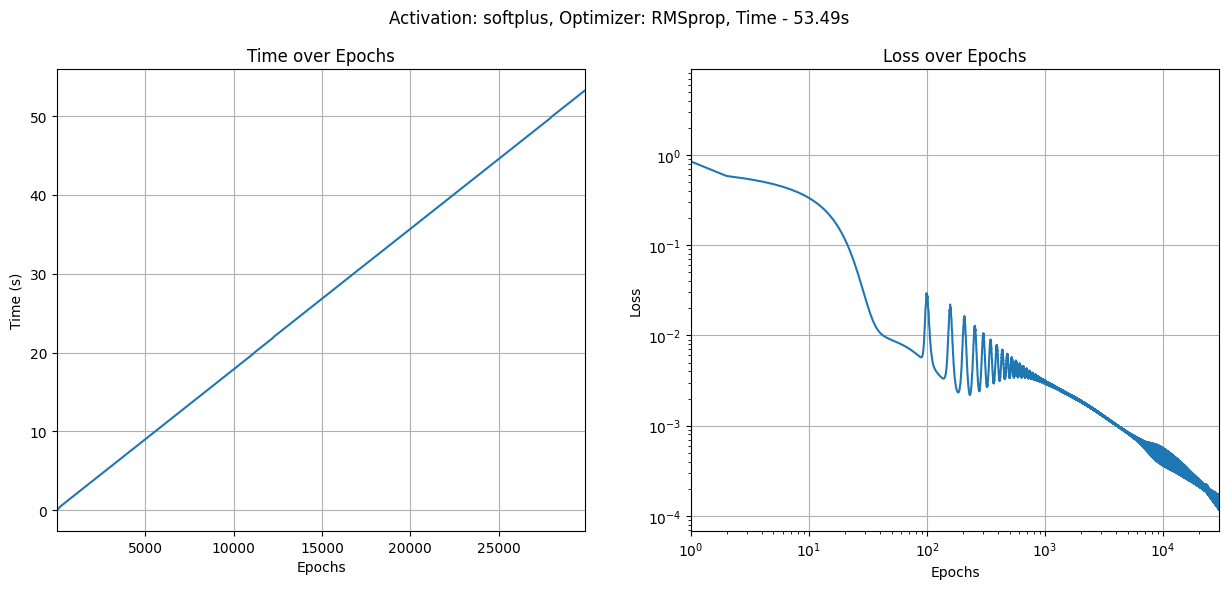

100%|██████████| 30000/30000 [01:04<00:00, 468.68it/s]


Training completed in 64.02s


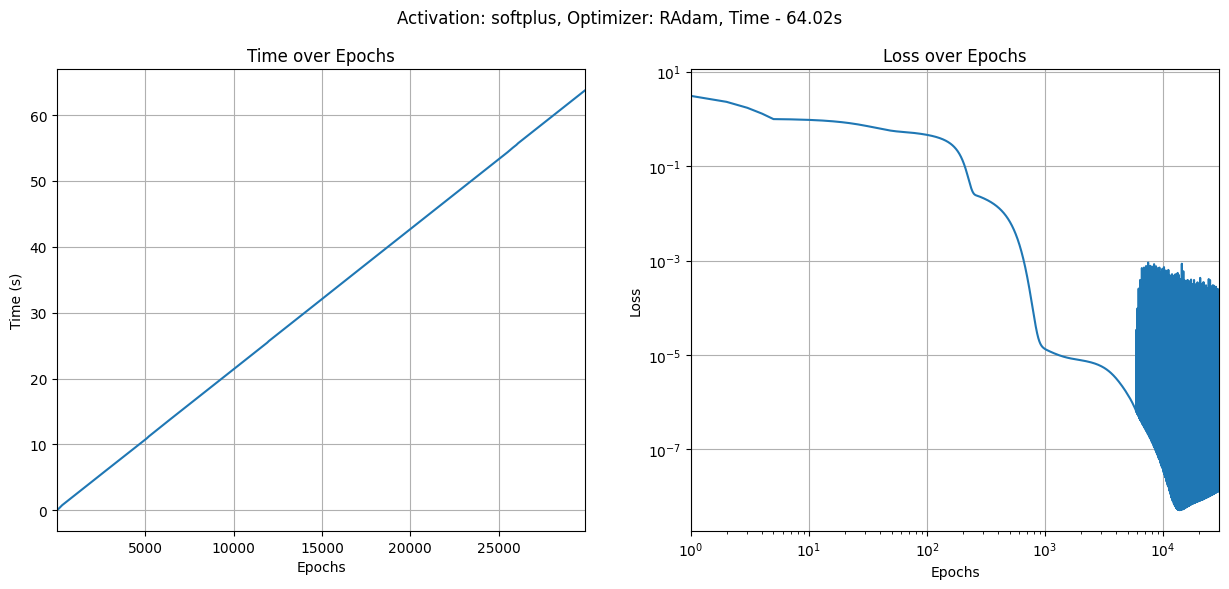

100%|██████████| 30000/30000 [00:58<00:00, 512.14it/s]


Training completed in 58.58s


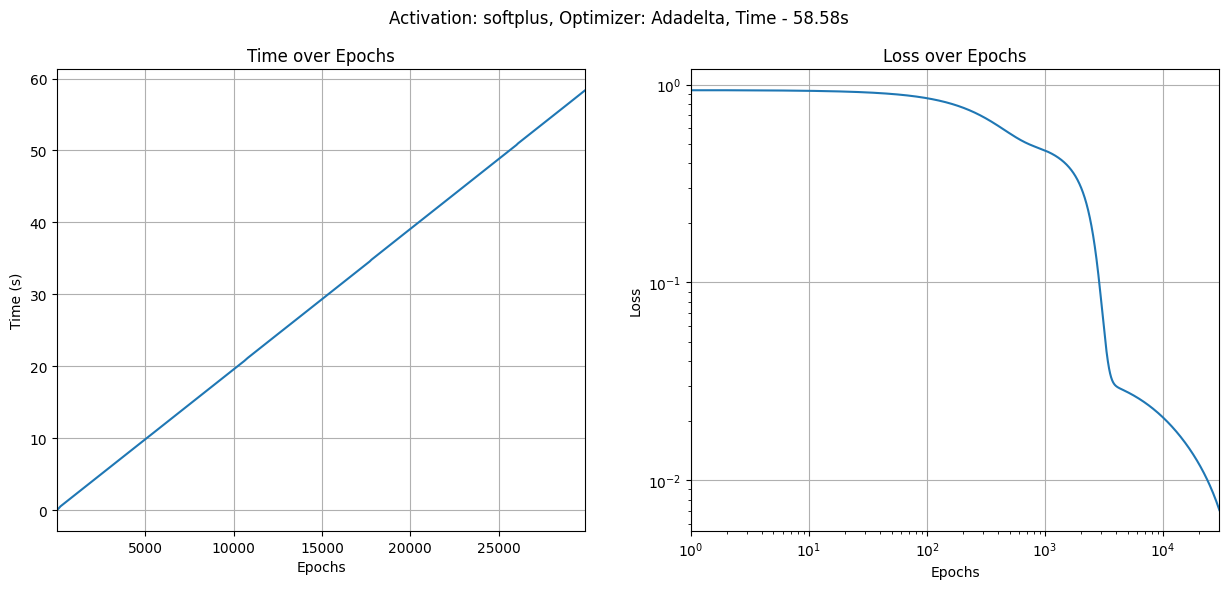

In [29]:
act_list_2 = ['tanh', 'sin', 'sigmoid', 'relu', 'softplus']
opt_list_2 = [optim.Adam, optim.SGD, optim.RMSprop, optim.RAdam, optim.Adadelta]

for act in act_list_2:
    for opt in opt_list_2:
        test_2(act, optimizer=opt)

## Conclusions

- In terms of accuracy, most combinations of activation functions and optimizers perform similarly, achieving an accuracy of around $10^{-5}$ to $10^{-7}$. The `ReLU` activation function, however, consistently shows worse performance across all optimizers, with accuracy around $10^{-3}$ to $10^{-4}$. This is consistent with the findings from Test 1, where `ReLU` also underperformed compared to other activation functions.
- The choice of optimizer does have an impact on the final accuracy, specifically, `Adam` and `RAdam` tend to yield the best results with all activation functions. `SGD` and `Adadelta` generally result in much lower accuracies. The `RMSprop` optimizer shows mixed results, with final accuracies similar to `Adam` for some activation functions, but with very early fluctuations in loss.
- The time taken for training varies significantly with the choice of optimizer. `SGD` is the fastest optimizer, followed by `RMSprop`. `Adam` and `Adadelta` take longer, with `RAdam` being the slowest. 
- For the choice of optimizer, `Adam` is a very common choice for a reason, as it provides a good balance between speed and accuracy. `RAdam` might provide slightly better accuracy, but if a time cost is a concern, `Adam` is a better choice. `RMSprop` is also a good choice if the user wants a faster optimizer and is willing to sacrifice some accuracy. If the computational cost is very important, and the user is willing to accept lower accuracy, `SGD` is a viable option. With regards to `Adadelta`, it is as slow as `RAdam`, but provides much lower accuracy, so it is not recommended for PINNs.  
- There is no clear non-linear relationship between the choice of optimizer and the time taken for training. 

# TEST 3 
Loss vs Epochs for different activation functions and optimizers.
Test configurations are the same as in Test 2.

The motivation behind this test is to compare the loss curves for different optimizers and activation functions, and essentially explore the conclusions from Test 2 in more detail.

In [30]:
act_list_2 = ['tanh', 'sin', 'sigmoid', 'relu', 'softplus']
opt_list_2 = [optim.Adam, optim.SGD, optim.RMSprop, optim.RAdam, optim.Adadelta]
params_dict = {}

for act in act_list_2:
    for opt in opt_list_2:
        opt_str = str(opt).split('.')[-1].split("'")[0]
        params_dict[(act, opt_str)] = test_2(act, optimizer=opt, plot=False)

        print(f'Activation: {act}, Optimizer: {opt_str}, Time - {params_dict[(act, opt_str)].time:.2f}s')

100%|██████████| 30000/30000 [00:52<00:00, 569.79it/s]


Training completed in 52.65s
Activation: tanh, Optimizer: Adam, Time - 52.65s


100%|██████████| 30000/30000 [00:41<00:00, 723.72it/s]


Training completed in 41.46s
Activation: tanh, Optimizer: SGD, Time - 41.46s


100%|██████████| 30000/30000 [00:48<00:00, 614.95it/s]


Training completed in 48.79s
Activation: tanh, Optimizer: RMSprop, Time - 48.79s


100%|██████████| 30000/30000 [00:59<00:00, 505.42it/s]


Training completed in 59.36s
Activation: tanh, Optimizer: RAdam, Time - 59.36s


100%|██████████| 30000/30000 [00:53<00:00, 559.93it/s]


Training completed in 53.58s
Activation: tanh, Optimizer: Adadelta, Time - 53.58s


100%|██████████| 30000/30000 [00:55<00:00, 540.60it/s]


Training completed in 55.50s
Activation: sin, Optimizer: Adam, Time - 55.50s


100%|██████████| 30000/30000 [00:44<00:00, 671.38it/s]


Training completed in 44.69s
Activation: sin, Optimizer: SGD, Time - 44.69s


100%|██████████| 30000/30000 [00:51<00:00, 577.97it/s]


Training completed in 51.91s
Activation: sin, Optimizer: RMSprop, Time - 51.91s


100%|██████████| 30000/30000 [01:02<00:00, 480.40it/s]


Training completed in 62.45s
Activation: sin, Optimizer: RAdam, Time - 62.45s


100%|██████████| 30000/30000 [00:57<00:00, 524.19it/s]


Training completed in 57.23s
Activation: sin, Optimizer: Adadelta, Time - 57.23s


100%|██████████| 30000/30000 [00:51<00:00, 582.11it/s]


Training completed in 51.54s
Activation: sigmoid, Optimizer: Adam, Time - 51.54s


100%|██████████| 30000/30000 [00:40<00:00, 738.90it/s]


Training completed in 40.60s
Activation: sigmoid, Optimizer: SGD, Time - 40.60s


100%|██████████| 30000/30000 [00:47<00:00, 625.92it/s]


Training completed in 47.93s
Activation: sigmoid, Optimizer: RMSprop, Time - 47.93s


100%|██████████| 30000/30000 [00:58<00:00, 512.10it/s]


Training completed in 58.59s
Activation: sigmoid, Optimizer: RAdam, Time - 58.59s


100%|██████████| 30000/30000 [00:52<00:00, 566.20it/s]


Training completed in 52.99s
Activation: sigmoid, Optimizer: Adadelta, Time - 52.99s


100%|██████████| 30000/30000 [00:50<00:00, 597.05it/s]


Training completed in 50.25s
Activation: relu, Optimizer: Adam, Time - 50.25s


100%|██████████| 30000/30000 [00:38<00:00, 770.87it/s]


Training completed in 38.92s
Activation: relu, Optimizer: SGD, Time - 38.92s


100%|██████████| 30000/30000 [00:47<00:00, 628.80it/s]


Training completed in 47.71s
Activation: relu, Optimizer: RMSprop, Time - 47.71s


100%|██████████| 30000/30000 [00:57<00:00, 523.97it/s]


Training completed in 57.26s
Activation: relu, Optimizer: RAdam, Time - 57.26s


100%|██████████| 30000/30000 [00:51<00:00, 579.18it/s]


Training completed in 51.80s
Activation: relu, Optimizer: Adadelta, Time - 51.80s


100%|██████████| 30000/30000 [00:57<00:00, 526.17it/s]


Training completed in 57.02s
Activation: softplus, Optimizer: Adam, Time - 57.02s


100%|██████████| 30000/30000 [00:45<00:00, 653.14it/s]


Training completed in 45.94s
Activation: softplus, Optimizer: SGD, Time - 45.94s


100%|██████████| 30000/30000 [00:53<00:00, 561.79it/s]


Training completed in 53.41s
Activation: softplus, Optimizer: RMSprop, Time - 53.41s


100%|██████████| 30000/30000 [01:03<00:00, 469.29it/s]


Training completed in 63.93s
Activation: softplus, Optimizer: RAdam, Time - 63.93s


100%|██████████| 30000/30000 [00:58<00:00, 512.41it/s]

Training completed in 58.55s
Activation: softplus, Optimizer: Adadelta, Time - 58.55s


In [31]:
color_list = ['C0', 'C1', 'C2', 'C4', 'C9']

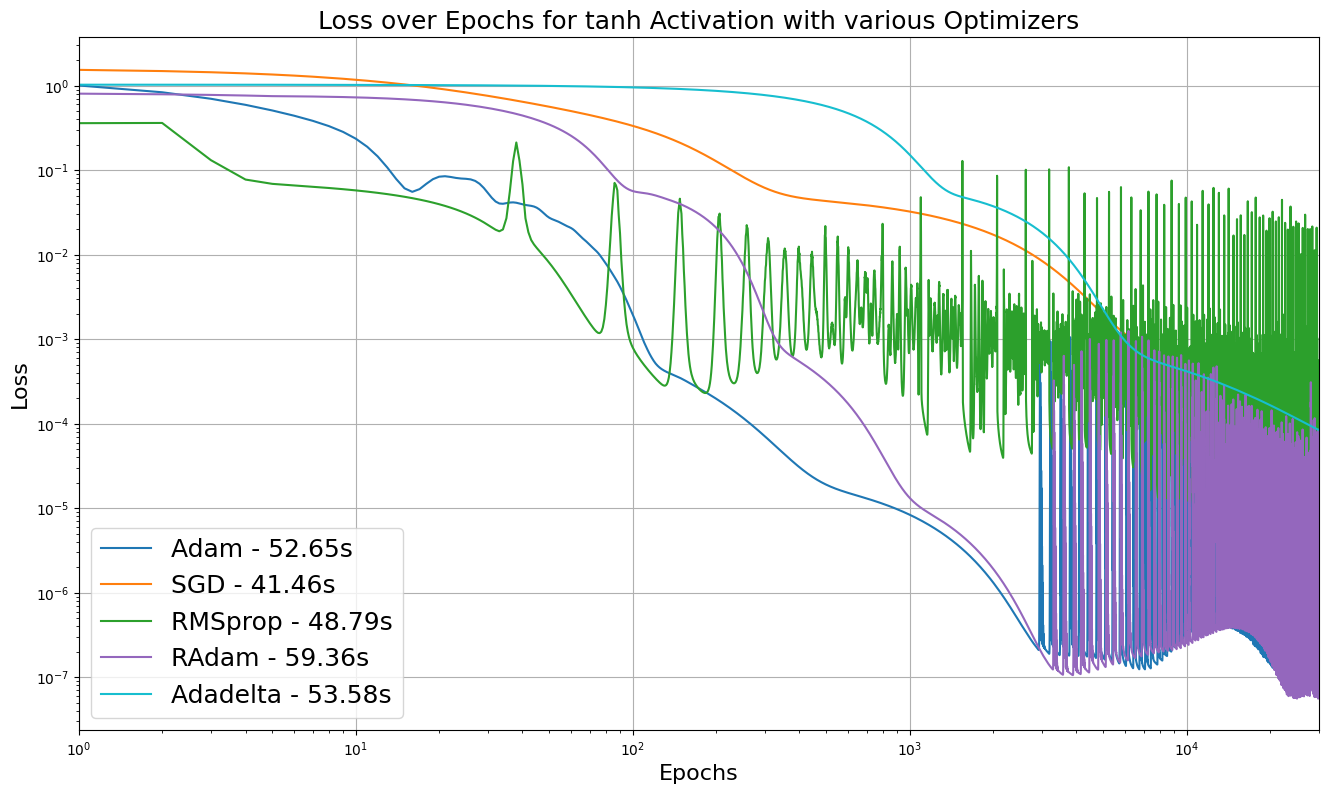

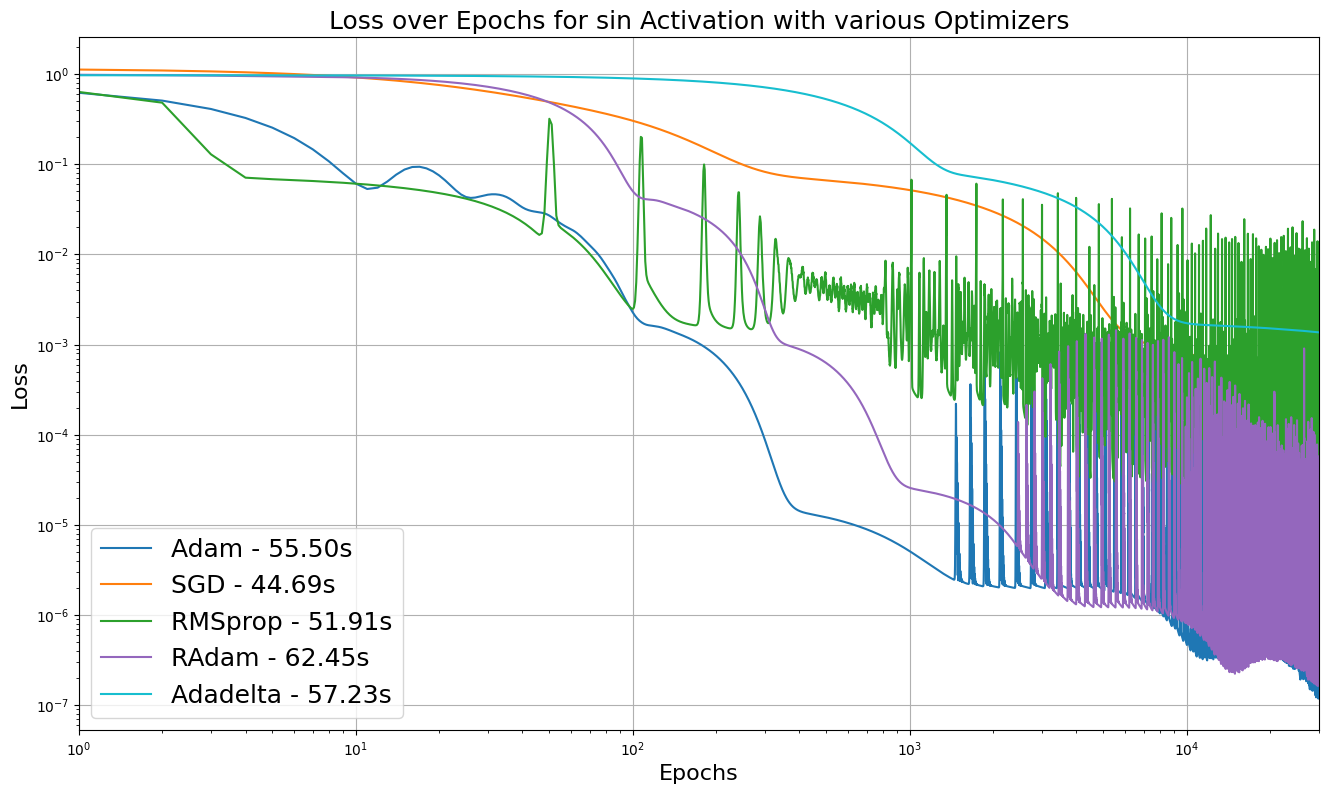

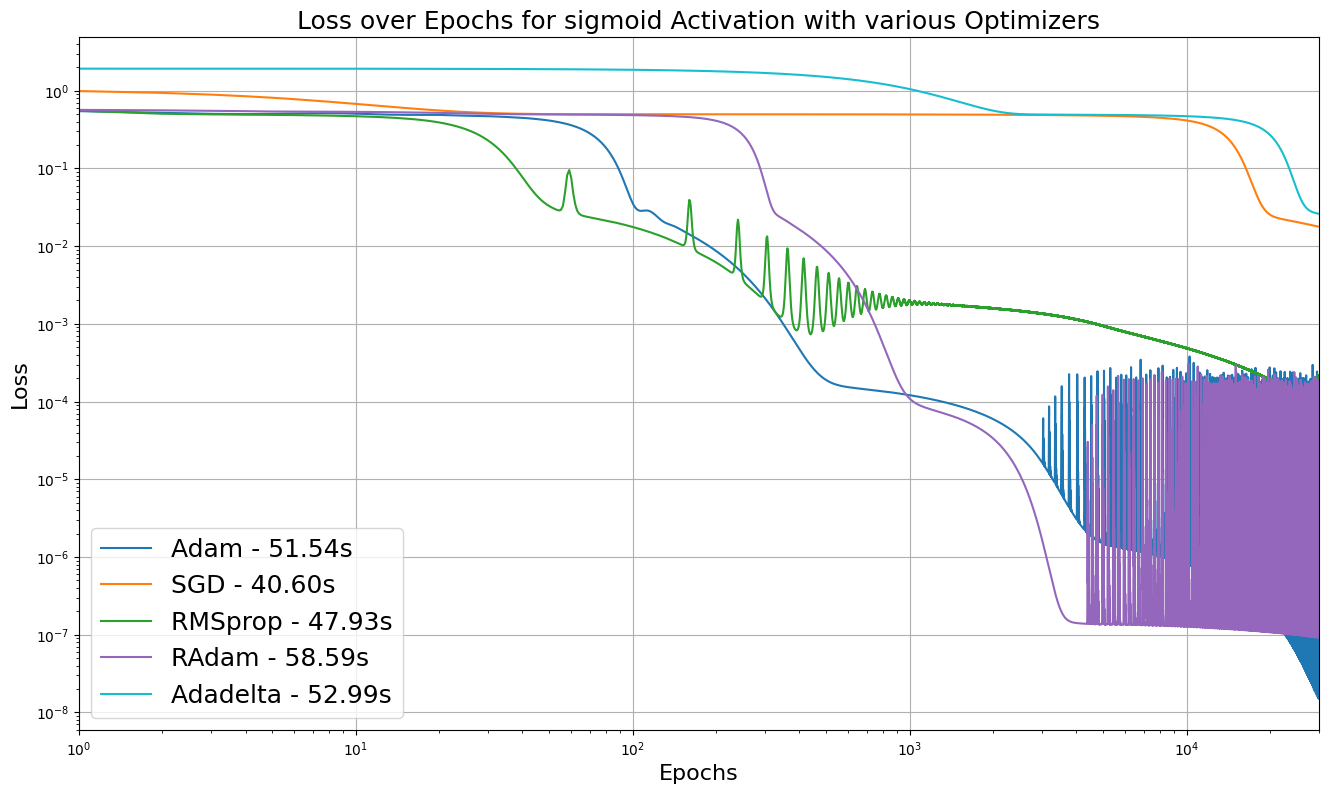

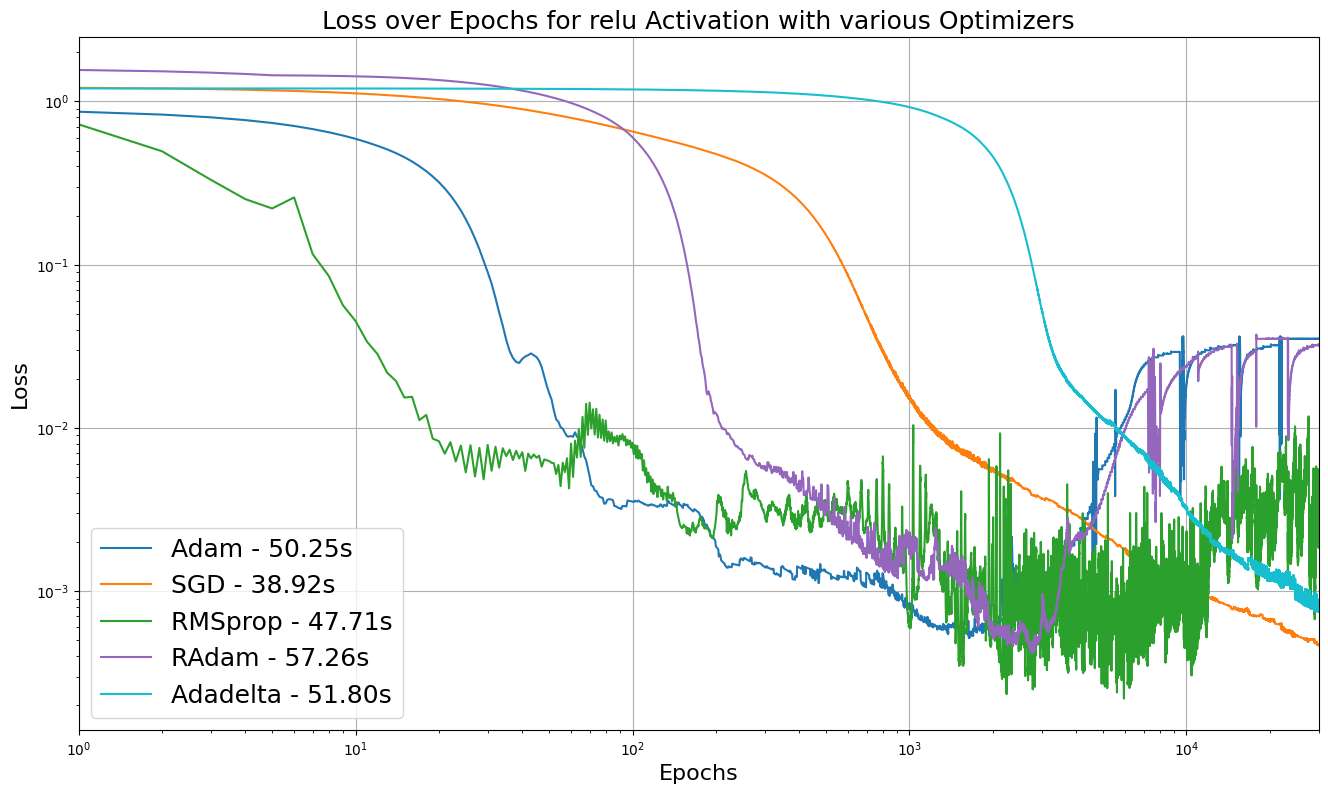

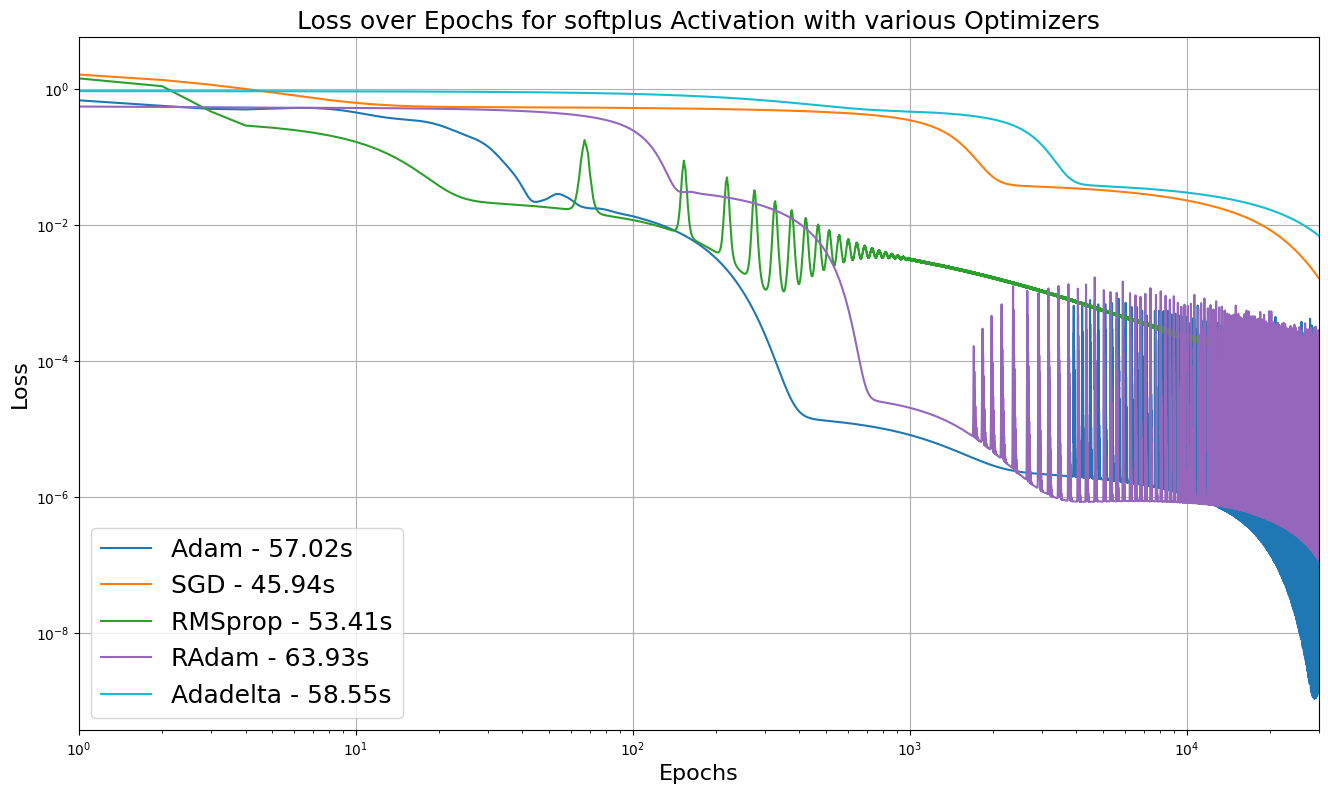

In [32]:
for act in act_list_2:
    plt.figure(figsize=(16, 9))
    for opt in opt_list_2:
        opt_str = str(opt).split('.')[-1].split("'")[0]
        plt.loglog(params_dict[(act, opt_str)].epochs, params_dict[(act, opt_str)].loss,
                   color=color_list[opt_list_2.index(opt)],
                   label = f'{opt_str} - {params_dict[(act, opt_str)].time:.2f}s')
    plt.xlim(1, 3e4)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(f'Loss over Epochs for {act} Activation with various Optimizers', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.show()

## Conclusions - 1

- Consistently with the previous tests, `Adam` and `RAdam` optimizers achieve the lowest loss across all activation functions except `ReLU`. `SGD` and `Adadelta` show the highest loss values (except for `ReLU`).
- The `ReLU` activation function consistently shows the highest loss values across all optimizers. However, for the `ReLU` function the `RMSprop` optimizer achieves the lowest or comparable loss to `Adam` and `RAdam`. `SGD` and `Adadelta` also appear to result in similar loss values at later epochs.
- The `Sigmoid` activation function achieves the loss values of around $10^{-8}$ with `Adam` and `RAdam`, and is the 2nd fastest after `ReLU`. This makes it a very good choice for PINNs, as it provides a good balance between speed and accuracy.
- The `Softplus` activation function also reaches low loss values of around $10^{-8}$ with `Adam` and `RAdam`, but is the slowest among all activation functions. 
- One more observation is that the loss curves for `RMSprop` show less fluctuations when used with `Sigmoid` and `Softplus` activation functions. Also, despite these functions resulting in the lowest loss values with `Adam` and `RAdam`, they converge a bit slower than `Tanh` and `Sin`, but this is balanced by later convergence to lower loss values.


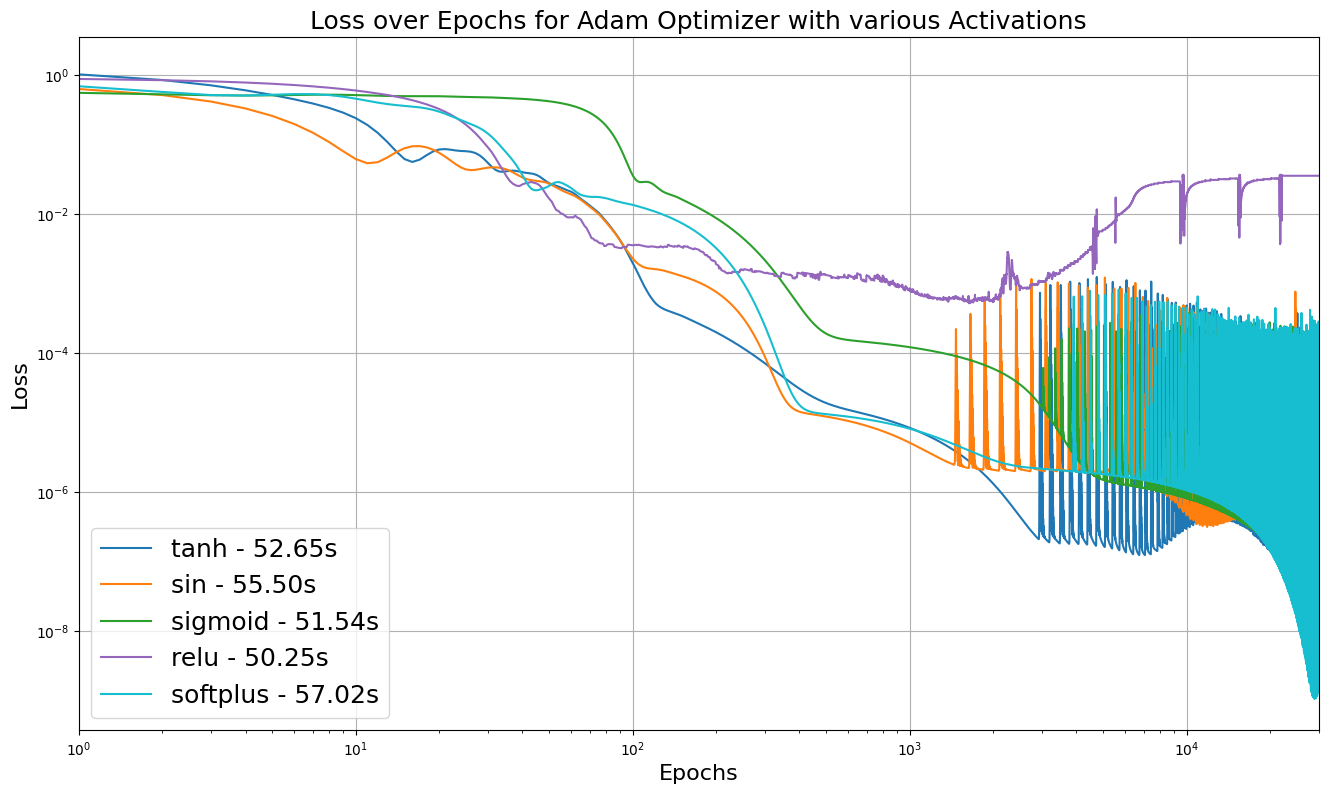

In [33]:
plt.figure(figsize=(16, 9))

for act in act_list_2:
    plt.loglog(params_dict[(act, 'Adam')].epochs, params_dict[(act, 'Adam')].loss,
               color=color_list[act_list_2.index(act)],
               label = f'{act} - {params_dict[(act, "Adam")].time:.2f}s')
plt.xlim(1, 3e4)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title(f'Loss over Epochs for Adam Optimizer with various Activations', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

## Conclusions - 2

For the follow-up, we decided to use `Adam` optimizer and compare different activation functions.

- The `Softplus` activation function achieves the lowest loss values of around $10^{-8}$, but is the slowest among all activation functions.
- The `Sigmoid` activation function reaches similar loss values of around $10^{-8}$, but is significantly faster.
- The `Tanh` and `Sin` activation functions achieve loss values of around $10^{-6} - 10^{-7}$, and are faster than `Softplus` but slower than `Sigmoid`.
- The `ReLU` activation function shows the highest loss values of around $10^{-3} - 10^{-4}$, and is the fastest among all activation functions. However, its performance is not satisfactory for PINNs.

In [34]:
for act in act_list_2:
    for opt in opt_list_2:
        opt_str = str(opt).split('.')[-1].split("'")[0]
        time_taken = params_dict[(act, opt_str)].time
        print(f'Activation: {act}, Optimizer: {opt_str}, Time - {time_taken:.2f}s')

Activation: tanh, Optimizer: Adam, Time - 52.65s
Activation: tanh, Optimizer: SGD, Time - 41.46s
Activation: tanh, Optimizer: RMSprop, Time - 48.79s
Activation: tanh, Optimizer: RAdam, Time - 59.36s
Activation: tanh, Optimizer: Adadelta, Time - 53.58s
Activation: sin, Optimizer: Adam, Time - 55.50s
Activation: sin, Optimizer: SGD, Time - 44.69s
Activation: sin, Optimizer: RMSprop, Time - 51.91s
Activation: sin, Optimizer: RAdam, Time - 62.45s
Activation: sin, Optimizer: Adadelta, Time - 57.23s
Activation: sigmoid, Optimizer: Adam, Time - 51.54s
Activation: sigmoid, Optimizer: SGD, Time - 40.60s
Activation: sigmoid, Optimizer: RMSprop, Time - 47.93s
Activation: sigmoid, Optimizer: RAdam, Time - 58.59s
Activation: sigmoid, Optimizer: Adadelta, Time - 52.99s
Activation: relu, Optimizer: Adam, Time - 50.25s
Activation: relu, Optimizer: SGD, Time - 38.92s
Activation: relu, Optimizer: RMSprop, Time - 47.71s
Activation: relu, Optimizer: RAdam, Time - 57.26s
Activation: relu, Optimizer: Adadel